# 2 EDA: Breast Cancer Gene Expressions

## 2.1 Contents <a id='2.1_Contents'></a>

* [2 Exploratory Data Analysis](#2_EDA)
    * [2.1 Contents](#2.1_Contents)
    * [2.2 Introduction](#2.2_Introduction)
    * [2.3 Imports](#2.3_Imports)
    * [2.4 Loading the Data](#2.4_Loading)
    * [2.5 Clinical Data](#2.5_Clinical)
        *  [2.5.1 Feature Engineering Outcomes](#2.5.1_Feature)
        *  [2.5.2 Distribution of Clinical Attributes](#2.5.2_Distribution_Clinical)
        *  [2.5.3 Clinical Attributes vs. Outcomes](#'2.5.3_Attributes_Outcomes)
        *  [2.5.4 Are there similar distributions in the data for the different cohorts?](#2.5.4_Cohorts)
        *  [2.5.5 Correlations Between Clinical Attributes](#2.5.5_Attributes_Correlations)
        *  [2.5.5a Impute the Missing Tumor Size](#2.5.5a_impute_tumor_size)
        *  [2.5.6 Correlation Matrix](#2.5.6_correlation_matrix)
    * [2.6 Z Score Data](#2.6_z_score)
        *  [2.6.1 How are the z scores connected to the genetic mutation data?](#2.6.1_z_score_mutation)
        *  [2.6.2 Z Score Outcomes](#2.6.2_z_score_outcomes)
        *  [2.6.2a Z Score Distributions](#2.6.2a_z_score_dist)
        *  [2.6.2b P-Values for Z Scores](#2.6.2a_p_values)
        *  [2.6.3 Correlation of Z Scores and Outcome](#2.6.3_corr)
    *  [2.7 Genetic Mutation Data](#2.6.7_genetic)
        *  [2.7.1 Convert gene mutation columns into binary](#2.7.1_binary)
        *  [2.7.2 Correlations of Mutation Data](#2.7.2_corr)
    *  [2.8 Preparation for Export](#2.8_prep)
    *  [2.9 Explort the Data](#2.9_export)
    *  [2.10 Summary](#2.10_summary)
    

## 2.2 Introduction <a id='2.2_Introduction'></a>

In the previous notebook, I cleaned and wrangled the Metabric Breast Cancer Gene Expression Profiles data, and now I will do exploratory data analysis. The data was sourced from https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric. 

In this notebook I will explore these questions: 

* What is the distribution of the different clinical attributes?
* How are the z scores connected to the genetic mutation data? (i.e. are there z scores associated with each mutation?)
* Can we drop the 'Stage' data entirely based on other clinical attributes that have less missing data? That is the one missing so much. 
* Are there similar distributions in the data for the different cohorts? 
* What does it look like when we compare presence of genetic mutations with outcomes?  
* Are there any correlations between outcomes and our data? 


## 2.3 Imports  <a id='2.3_Imports'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import statsmodels.api as sm
from scipy import stats
import missingno as msno
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [2]:
# setting the display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## 2.4 Loading the Data <a id='2.4_Loading'></a>

In [3]:
# importing using parquet to preserve data types

cancer_data=pd.read_parquet(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\cancer_data_cleaned.parquet', engine='pyarrow')

In [4]:
cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Columns: 693 entries, patient_id to siah1_mut
dtypes: category(189), float64(495), int64(8), object(1)
memory usage: 8.0+ MB


checking my data types. Here I can see the mix of types for our clinical data, that the z scores are floats, and the mutations are categories. 

In [5]:
data_types= cancer_data.dtypes
data_types.head(32)

patient_id                           int64
age_at_diagnosis                   float64
type_of_breast_surgery            category
cancer_type                       category
cancer_type_detailed              category
cellularity                       category
chemotherapy                         int64
pam50_+_claudin-low_subtype       category
cohort                               int64
er_status_measured_by_ihc         category
er_status                         category
neoplasm_histologic_grade          float64
her2_status_measured_by_snp6      category
her2_status                       category
tumor_other_histologic_subtype    category
hormone_therapy                      int64
inferred_menopausal_state         category
integrative_cluster                 object
primary_tumor_laterality          category
lymph_nodes_examined_positive        int64
mutation_count                       int64
nottingham_prognostic_index        float64
oncotree_code                     category
overall_sur

In [6]:
data_types.tail()

hras_mut       category
prps2_mut      category
smarcb1_mut    category
stmn2_mut      category
siah1_mut      category
dtype: object

In [7]:
cancer_data.shape

(1903, 693)

In [8]:
cancer_data.describe()

patient_id  age_at_diagnosis  chemotherapy       cohort  \
count  1903.000000       1903.000000   1903.000000  1903.000000   
mean   3921.347346         61.088355      0.208092     2.643720   
std    2358.935544         12.981999      0.406050     1.228911   
min       0.000000         21.930000      0.000000     1.000000   
25%     896.000000         51.370000      0.000000     1.000000   
50%    4730.000000         61.780000      0.000000     3.000000   
75%    5537.500000         70.595000      0.000000     3.000000   
max    7299.000000         96.290000      1.000000     5.000000   

       neoplasm_histologic_grade  hormone_therapy  \
count                1831.000000      1903.000000   
mean                    2.415620         0.616921   
std                     0.650646         0.486265   
min                     1.000000         0.000000   
25%                     2.000000         0.000000   
50%                     3.000000         1.000000   
75%                     3.000000         1.000000   
max                     3.000000         1.000000   

       lymph_nodes_examined_positive  mutation_count  \
count                    1903.000000     1903.000000   
mean                        2.003153        5.559117   
std                         4.080807        4.100415   
min                         0.000000        0.000000   
25%                         0.000000        3.000000   
50%                         0.000000        5.000000   
75%                         2.000000        7.000000   
max                        45.000000       80.000000   

       nottingham_prognostic_index  overall_survival_months  overall_survival  \
count                  1903.000000              1903.000000       1903.000000   
mean                      4.033020               125.052549          0.420914   
std                       1.144792                76.295658          0.493836   
min                       1.000000                 0.000000          0.000000   
25%                       3.046000                60.800000          0.000000   
50%                       4.042000               115.600000          0.000000   
75%                       5.040500               184.550000          1.000000   
max                       6.360000               355.200000          1.000000   

       radio_therapy   tumor_size  tumor_stage        brca1        brca2  \
count    1903.000000  1883.000000  1402.000000  1903.000000  1903.000000   
mean        0.596952    26.244695     1.751070     0.000410     0.001073   
std         0.490639    15.162789     0.628904     1.000364     0.999428   
min         0.000000     1.000000     0.000000    -2.444400    -2.783500   
25%         0.000000    17.000000     1.000000    -0.718300    -0.698550   
50%         1.000000    23.000000     2.000000    -0.124000    -0.057800   
75%         1.000000    30.000000     2.000000     0.553250     0.629000   
max         1.000000   182.000000     4.000000     4.554200     3.737900   

             palb2         pten         tp53          atm         cdh1  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean     -0.001062    -0.000312    -0.000356     0.001180     0.000214   
std       0.999451     1.000433     1.000404     0.999198     1.000483   
min      -4.384600    -5.932800    -2.481200    -3.170500    -3.323700   
25%      -0.680250    -0.558900    -0.666200    -0.658250    -0.459000   
50%      -0.023900     0.108700    -0.035200    -0.003200     0.115800   
75%       0.638400     0.642750     0.643050     0.690400     0.650100   
max       4.615000     3.254100     4.289800     3.824200     2.820900   

             chek2          nbn          nf1        stk11        bard1  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean     -0.000290    -0.000263     0.000074     0.000463    -0.000245   
std       1.000445     1.000460     1.000519     1.000321     1.000468   
min      -2.688700    -3.689800    -2.96860

## 2.5  Clinical Data <a id='2.5_Clinical'></a>

The clinical attributes are the section of the data where it should be the easiest to see patterns from simple graphical representation of the data without manipulation. Here I will explore the clinical attributes and see what stands out. 

### 2.5.1 Feature Engineering Outcomes <a id='2.5.1_Feature'></a>

In [9]:
#looking at survival rates - 0 = died, 1 = lived.

survival_counts = cancer_data['overall_survival'].value_counts()
print('Percents Died vs Survived:\n',100*survival_counts/len(cancer_data))

Percents Died vs Survived:
 0    57.908565
1    42.091435
Name: overall_survival, dtype: float64


How does this compare to the more detailed breakdown of outcomes in the death_from_cancer column?

In [10]:
cancer_survival_counts = cancer_data['death_from_cancer'].value_counts()
print('Outcomes:\n',100*cancer_survival_counts/len(cancer_data))

Outcomes:
 Living                  42.091435
Died of Disease         32.685234
Died of Other Causes    25.223332
Name: death_from_cancer, dtype: float64


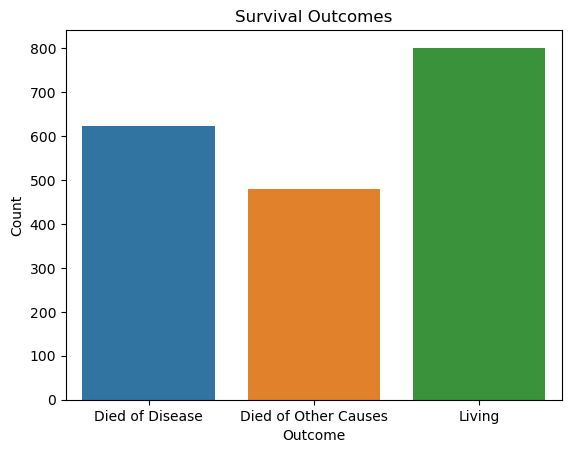

In [11]:
ax = sns.countplot(x='death_from_cancer', data=cancer_data)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Survival Outcomes')
plt.show()

Here we can see that about 33% of patients in this dataset died from breast cancer, 25% died of other causes, and 42% were alive a the end of the study. For our purposes, we only should look at this metric, as it is more detailed.

This is an unbalanced classification problem, where patients who lived are the majority class.

As we are interested in death due to breast cancer, we can combine the other outcomes (lived/death from other causes) together. 

In [12]:
# first change type from category to object:
cancer_data['death_from_cancer'] = cancer_data['death_from_cancer'].astype('str')

# Change to binary, where 0 means died from cancer
cancer_data.loc[cancer_data['death_from_cancer'] != 'Died of Disease', 'death_from_cancer'] = 1
cancer_data.loc[cancer_data['death_from_cancer'] == 'Died of Disease', 'death_from_cancer'] = 0

# change data type back to category
cancer_data['death_from_cancer'] = cancer_data['death_from_cancer'].astype('category')

In [13]:
cancer_data['death_from_cancer'].head()

0    1
1    1
2    0
3    1
4    0
Name: death_from_cancer, dtype: category
Categories (2, int64): [0, 1]

In [14]:
#show how much of our data died of cancer (0) and did not die of cancer (1).
death_counts = cancer_data['death_from_cancer'].value_counts()

print('Counts for Did Not Die of Disease(1) vs Percents Died of Disease(0)\n',death_counts)

print('\n Did Not Die of Disease(1) vs Percents Died of Disease(0):\n',100*death_counts/len(cancer_data))

Counts for Did Not Die of Disease(1) vs Percents Died of Disease(0)
 1    1281
0     622
Name: death_from_cancer, dtype: int64

 Did Not Die of Disease(1) vs Percents Died of Disease(0):
 1    67.314766
0    32.685234
Name: death_from_cancer, dtype: float64


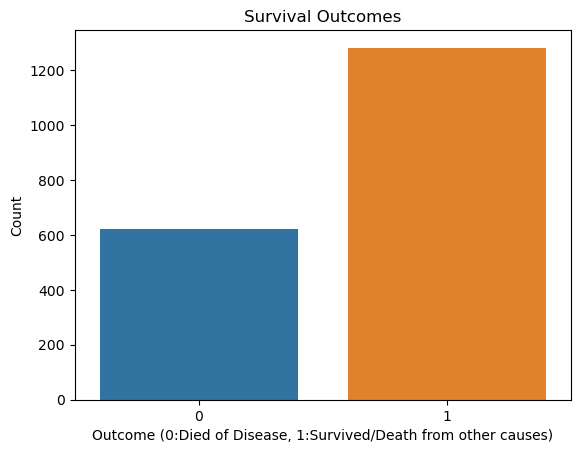

In [15]:
# plotting our newly reformatted death_from_cancer
ax = sns.countplot(x='death_from_cancer', data=cancer_data)
plt.xlabel('Outcome (0:Died of Disease, 1:Survived/Death from other causes)')
plt.ylabel('Count')
plt.title('Survival Outcomes')
plt.show()

### 2.5.2 Distribution of Clinical Attributes <a id='2.5.2_Distribution_Clinical'></a>

Below I will look at plots of my clinical data. First, I'm looking at value counts for categorical clinical data. I'm splitting them up into multiple blocks so that they are more readable.

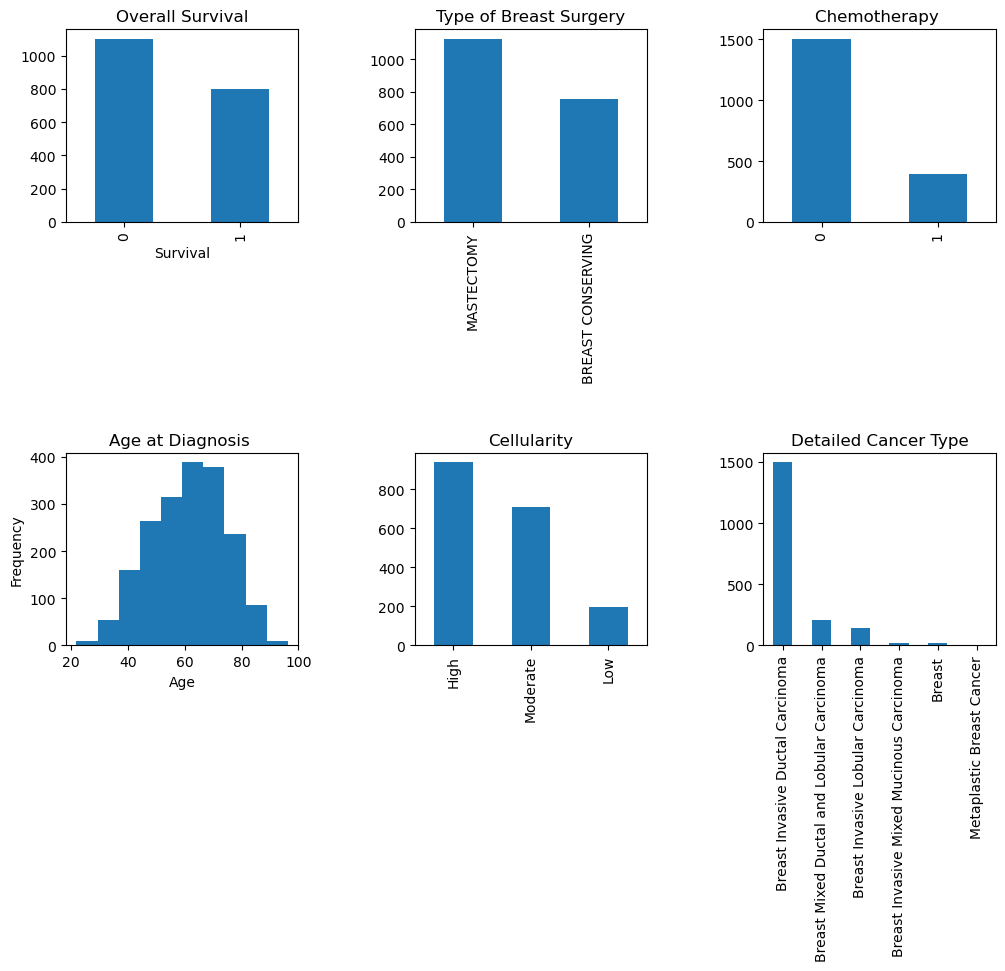

In [16]:
# doing sub plots in 3x2 grids
fig, ax = plt.subplots(2,3, figsize=(12,8))
cancer_data.overall_survival.value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('Overall Survival')
ax[0,0].set_xlabel('Survival')

cancer_data.type_of_breast_surgery.value_counts().plot(kind='bar', ax=ax[0,1])
ax[0,1].set_title('Type of Breast Surgery')

cancer_data.chemotherapy.value_counts().plot(kind='bar', ax=ax[0,2])
ax[0,2].set_title('Chemotherapy ')

cancer_data.age_at_diagnosis.plot(kind='hist', ax=ax[1,0])
ax[1,0].set_title('Age at Diagnosis ')
ax[1,0].set_xlabel('Age')


cancer_data.cellularity.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Cellularity')

cancer_data.cancer_type_detailed.value_counts().plot(kind='bar', ax=ax[1,2])
ax[1,2].set_title('Detailed Cancer Type')

plt.subplots_adjust(wspace=0.5, hspace=1.2);


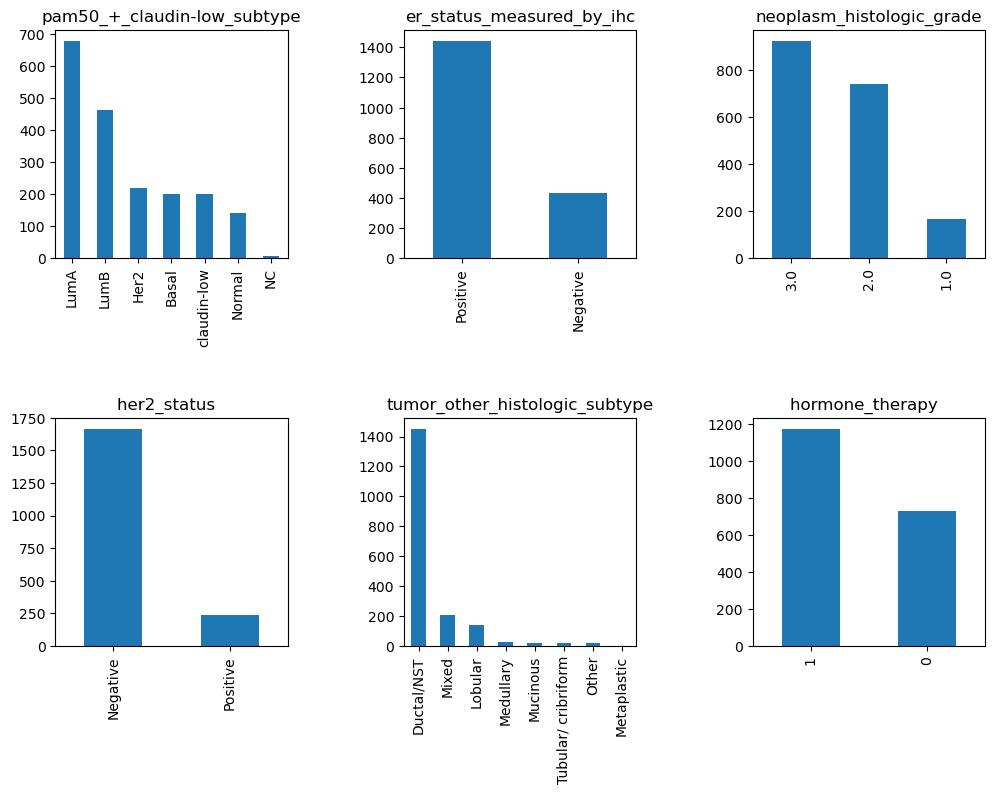

In [17]:

fig, ax = plt.subplots(2,3, figsize=(12,8))
cancer_data['pam50_+_claudin-low_subtype'].value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('pam50_+_claudin-low_subtype')

cancer_data.er_status_measured_by_ihc.value_counts().plot(kind='bar', ax=ax[0,1])
ax[0,1].set_title('er_status_measured_by_ihc')

cancer_data.neoplasm_histologic_grade.value_counts().plot(kind='bar', ax=ax[0,2])
ax[0,2].set_title('neoplasm_histologic_grade')

cancer_data.her2_status.value_counts().plot(kind='bar', ax=ax[1,0])
ax[1,0].set_title('her2_status  ')

cancer_data.tumor_other_histologic_subtype  .value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('tumor_other_histologic_subtype')

cancer_data.hormone_therapy  .value_counts().plot(kind='bar', ax=ax[1,2])
ax[1,2].set_title('hormone_therapy  ')

plt.subplots_adjust(wspace=0.5, hspace=.7);

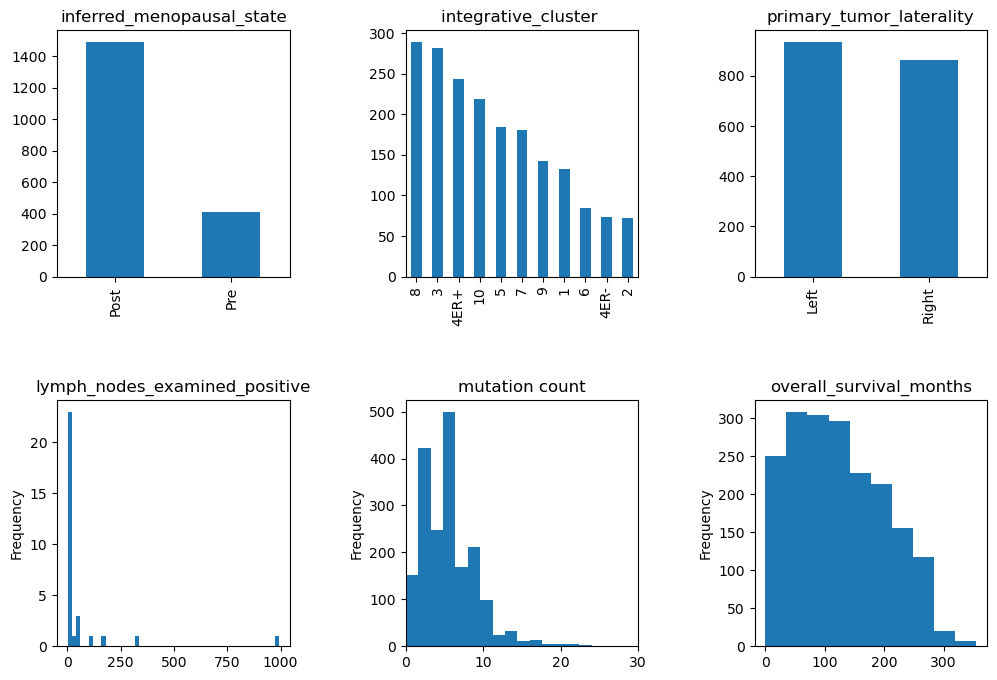

In [18]:

fig, ax = plt.subplots(2,3, figsize=(12,8))
cancer_data['inferred_menopausal_state'].value_counts().plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('inferred_menopausal_state')

cancer_data.integrative_cluster.value_counts().plot(kind='bar', ax=ax[0,1])
ax[0,1].set_title('integrative_cluster ')

cancer_data.primary_tumor_laterality.value_counts().plot(kind='bar', ax=ax[0,2])
ax[0,2].set_title('primary_tumor_laterality')

cancer_data.lymph_nodes_examined_positive.value_counts().plot(kind='hist', bins=50, ax=ax[1,0]) 
ax[1,0].set_title('lymph_nodes_examined_positive')

cancer_data.mutation_count.plot(kind='hist',bins=50, ax=ax[1,1])
ax[1,1].set_title('mutation count')
ax[1,1].set_xlim([0, 30])

cancer_data.overall_survival_months.plot(kind='hist', ax=ax[1,2])
ax[1,2].set_title('overall_survival_months')

plt.subplots_adjust(wspace=0.5, hspace=.5);

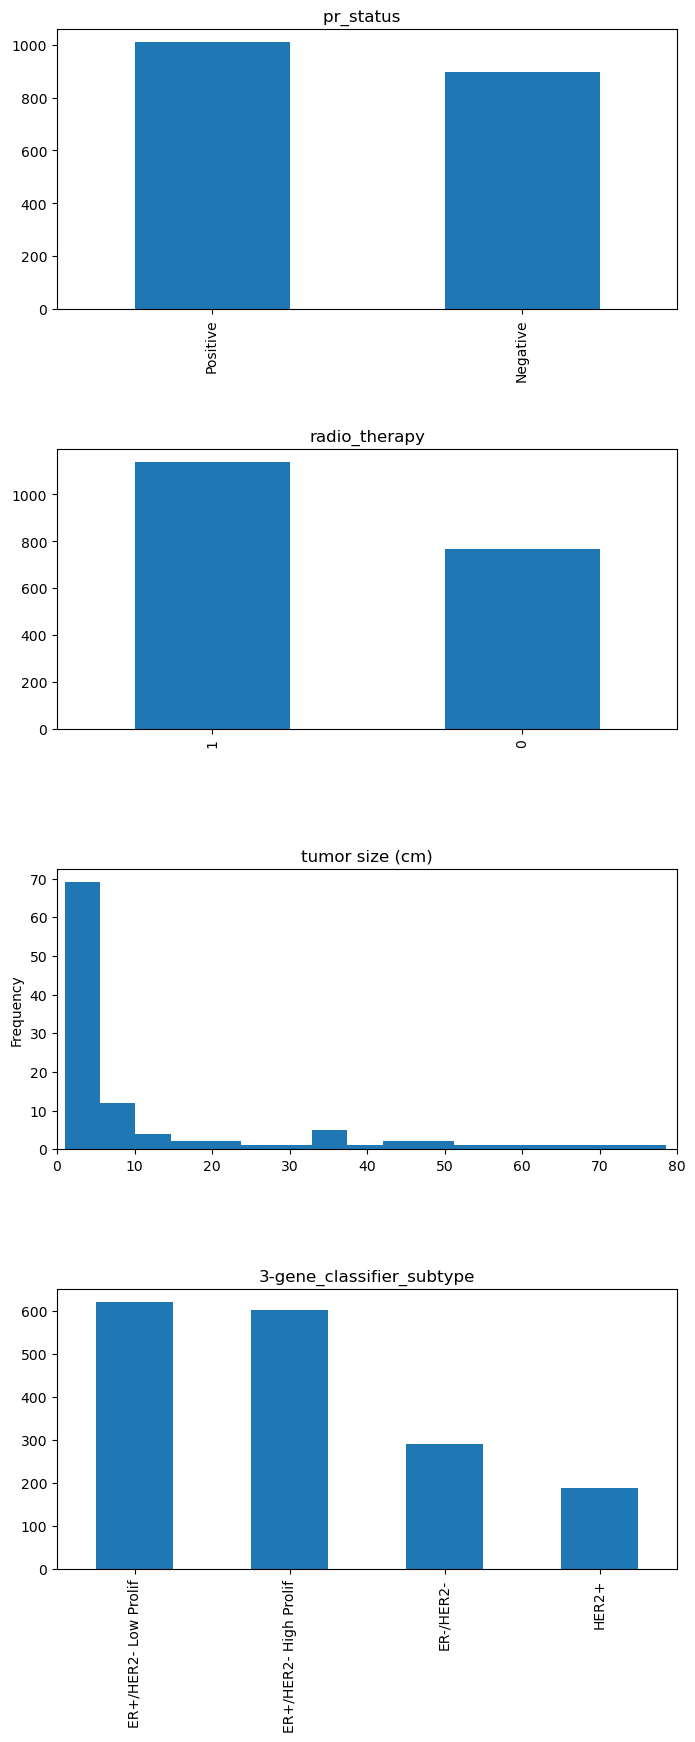

In [19]:

fig, ax = plt.subplots(4, figsize=(8, 20))

cancer_data['pr_status'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('pr_status  ')

cancer_data.radio_therapy.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('radio_therapy')

cancer_data['3-gene_classifier_subtype'].value_counts().plot(kind='bar', ax=ax[3])
ax[3].set_title('3-gene_classifier_subtype')

cancer_data.tumor_size.value_counts().plot(kind='hist',bins=50, ax=ax[2])
ax[2].set_title('tumor size (cm)')
ax[2].set_xlim(0, 80)

plt.subplots_adjust(wspace=0.5, hspace=.5)
plt.show();

In [20]:
# find the average age of patients in this study

average_age = cancer_data.age_at_diagnosis.mean()
rounded_average_age = round(average_age, 2)
print('average age is ', rounded_average_age)

median_age = cancer_data.age_at_diagnosis.median()
rounded_median_age = round(median_age, 2)
print('median age is ', rounded_median_age)

average age is  61.09
median age is  61.78


Our median and average age are both between 61 and 62. 

### Observations:

The proportions for death and getting a mastectomy are similar - I'm wondering if the patients that had breast conserving surgery had less severe disease and therefore were more likely to survive. I will look at this below in more detail.

Cancer type - the vast majority of cases were invasive ductal carcinoma

Age follows a rougly normal distribution, peaking around age 70. Most women were post menopausal, which makes sense given the age distribution.

Most patients did not get chemo, but did get radiotherapy and hormone therapy. The proportions with death and getting radiotherapy are roughly the same, and again I wonder if this is because more severe disease was present.

HER2 status for most patients was negative, ER status mostly positive

Most neoplasms were grade 3

Mutation counts peaked at 7

Positive lymph nodes looks to fall roughly exponentially

Left and right sides are about equal - I think we can take this out because I dont think it is relavent to survival

Tumor stage and tumor size have similar distributions (both left skewed), and I'm guessing they are usually similar

PR status roughly equal, but a little more positive.

### 2.5.3 Clinical Attributes vs. Outcomes  <a id='2.5.3_Attributes_Outcomes'></a>

### Treatment modality survival comparison

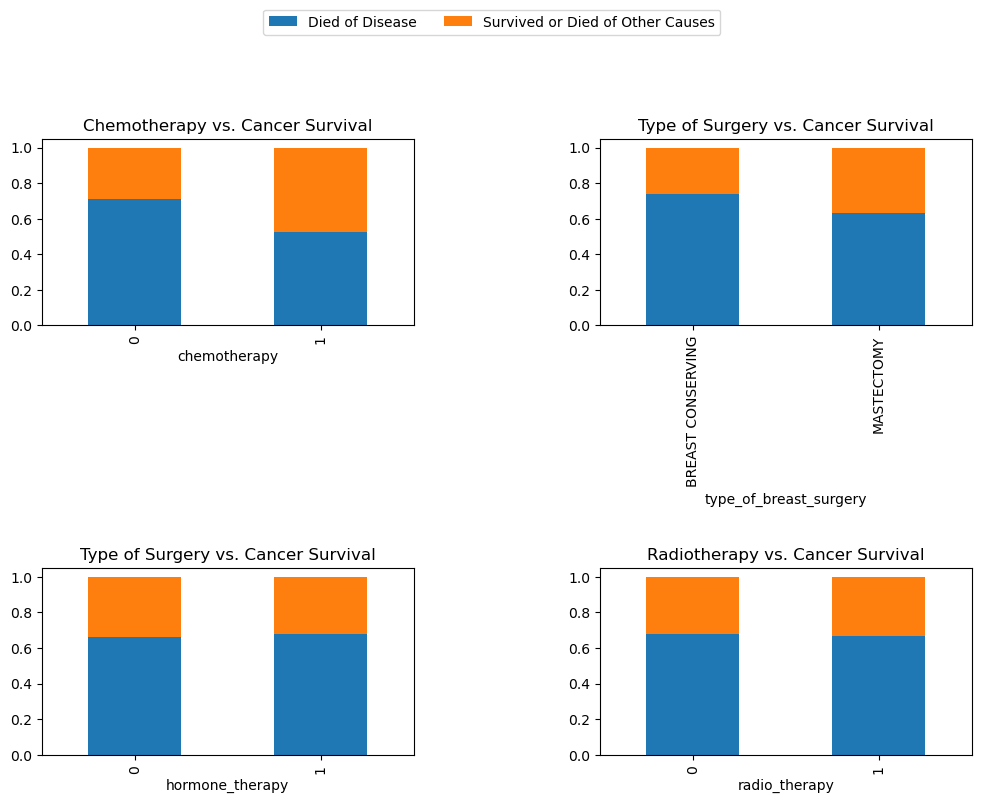

In [21]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
cancer_data.groupby('chemotherapy')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0, 0])
ax[0, 0].set_title('Chemotherapy vs. Cancer Survival')

cancer_data.groupby('type_of_breast_surgery')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0, 1])
ax[0, 1].set_title('Type of Surgery vs. Cancer Survival')

cancer_data.groupby('hormone_therapy')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1,0])
ax[1, 0].set_title('Type of Surgery vs. Cancer Survival')

cancer_data.groupby('radio_therapy')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1,1])
ax[1, 1].set_title('Radiotherapy vs. Cancer Survival')

#Remove legends in subplots:
for a in ax.flat:
    if a.get_legend():
        a.get_legend().remove()

# common legend outside the subplots
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles,  ['Died of Disease', 'Survived or Died of Other Causes'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)


plt.subplots_adjust(wspace=0.5, hspace=1.3)
plt.show();


Hormone Therapy and Radiotherapy have roughly the same outcome for those who died of concer and those who did not. It looks like more people died of cancer who did not get chemotherapy and who got breast conserving surgery. 

### Tumor Size vs. Outcome

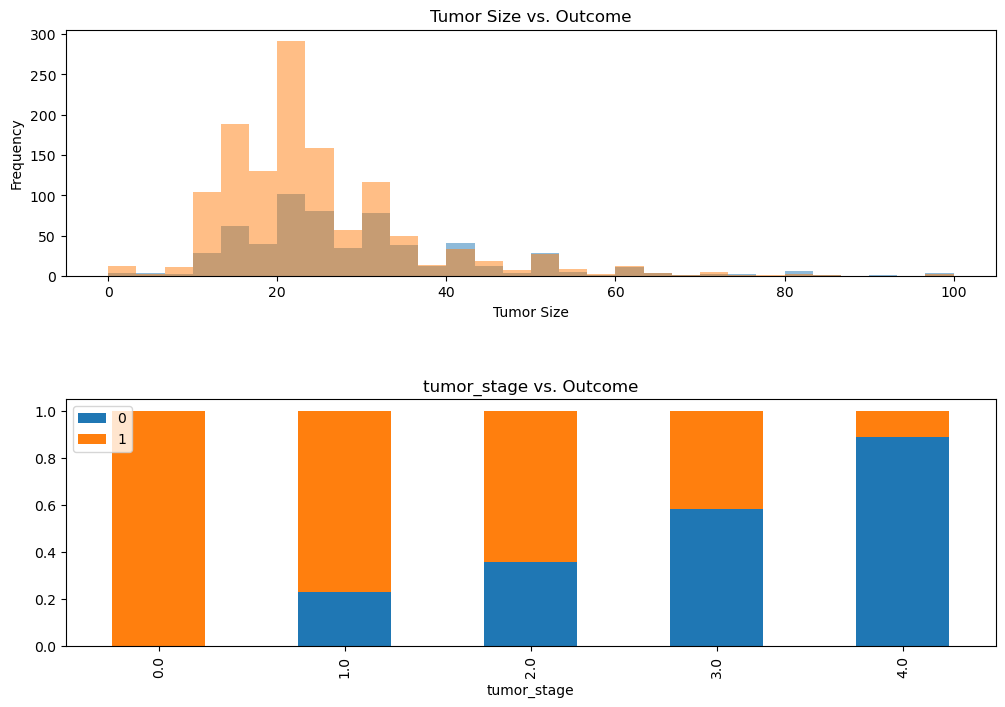

In [22]:
fig, ax = plt.subplots(2, figsize=(12,8))

cancer_data[cancer_data['death_from_cancer'] == 0]['tumor_size'].plot.hist(ax=ax[0], alpha=0.5, stacked=True, range=[0,100], bins=30)
cancer_data[cancer_data['death_from_cancer'] == 1]['tumor_size'].plot.hist(ax=ax[0], alpha=0.5, stacked=True,range=[0,100], bins=30)
ax[0].set_title('Tumor Size vs. Outcome')
ax[0].set_xlabel('Tumor Size')

cancer_data.groupby('tumor_stage')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('tumor_stage vs. Outcome')

plt.subplots_adjust(wspace=0.5, hspace=.5)
plt.show();


The tumor stage has a clear relationship with outcomes. This is also unfortunately the feature that one of the cohorts didn't record data for, so we are missing about 26% of the data from this column. 

### Plots of Clinical Attributes vs Outcomes

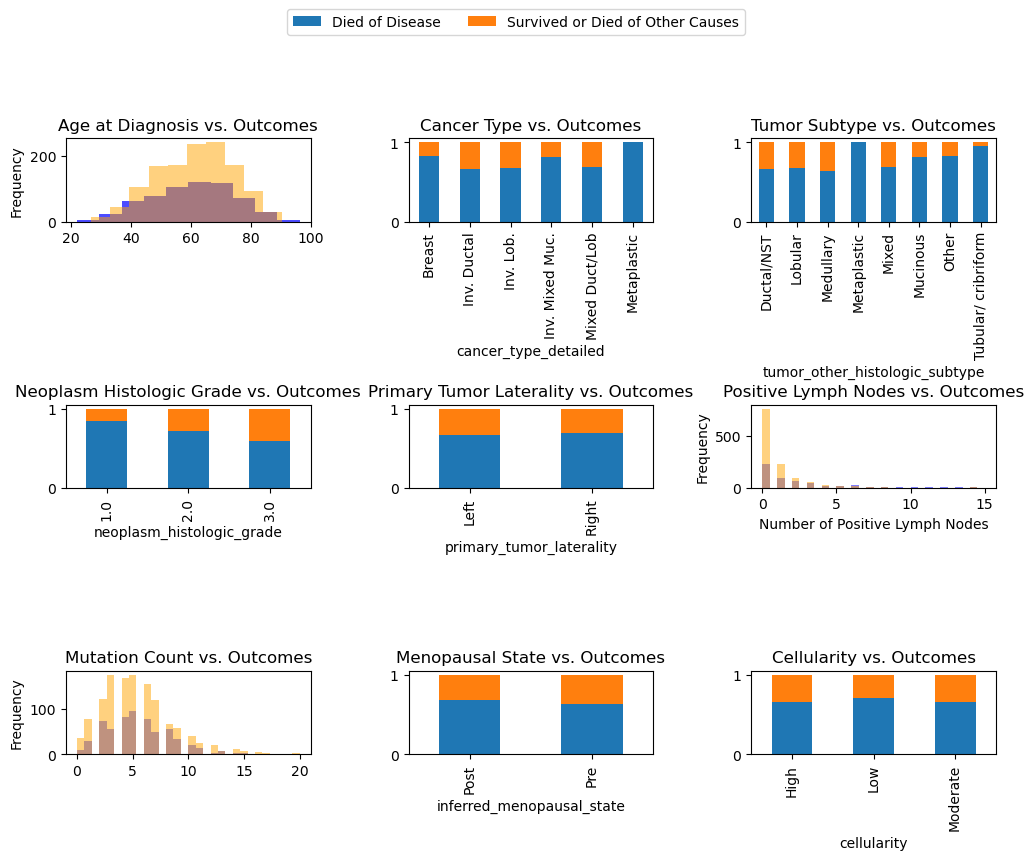

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(12,8))

#doing a histogram for age data
cancer_data[cancer_data['death_from_cancer'] == 0]['age_at_diagnosis'].plot.hist(ax=ax[0, 0], alpha=0.7, color='blue', stacked=True)
cancer_data[cancer_data['death_from_cancer'] == 1]['age_at_diagnosis'].plot.hist(ax=ax[0, 0], alpha=0.5, color='orange', stacked=True)
ax[0, 0].set_title('Age at Diagnosis vs. Outcomes')
ax[0,0].legend(['Died of disease', 'Did not die of disease'])


cancer_data.groupby('cancer_type_detailed')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0,1])
ax[0, 1].set_title('Cancer Type vs. Outcomes')
ax[0, 1].set_xticklabels(['Breast', 'Inv. Ductal', 'Inv. Lob.','Inv. Mixed Muc.', 'Mixed Duct/Lob', 'Metaplastic'])

cancer_data.groupby('tumor_other_histologic_subtype')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0,2])
ax[0, 2].set_title('Tumor Subtype vs. Outcomes')

cancer_data.groupby('neoplasm_histologic_grade')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1,0])
ax[1, 0].set_title('Neoplasm Histologic Grade vs. Outcomes')

cancer_data.groupby('primary_tumor_laterality')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1,1])
ax[1,1].set_title('Primary Tumor Laterality vs. Outcomes')

cancer_data[cancer_data['death_from_cancer'] == 0]['lymph_nodes_examined_positive'].plot.hist(ax=ax[1,2], alpha=0.5, color = 'blue', stacked=True,range=[0,15], bins=30)
cancer_data[cancer_data['death_from_cancer'] == 1]['lymph_nodes_examined_positive'].plot.hist(ax=ax[1,2], alpha=0.5, color = 'orange', stacked=True, range=[0,15],bins=30)
ax[1, 2].set_title('Positive Lymph Nodes vs. Outcomes')
ax[1,2].set_xlabel('Number of Positive Lymph Nodes')

cancer_data[cancer_data['death_from_cancer'] == 0]['mutation_count'].plot.hist(ax=ax[2,0], alpha=0.5, color = 'blue', stacked=True, range=[0,20], bins=30)
cancer_data[cancer_data['death_from_cancer'] == 1]['mutation_count'].plot.hist(ax=ax[2,0], alpha=0.5, color = 'orange', stacked=True, range=[0,20],bins=30)
ax[2,0].set_title('Mutation Count vs. Outcomes')


cancer_data.groupby('inferred_menopausal_state')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[2,1])
ax[2, 1].set_title('Menopausal State vs. Outcomes')


cancer_data.groupby('cellularity')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[2, 2])
ax[2, 2].set_title('Cellularity vs. Outcomes')


#Remove legends in subplots:
for a in ax.flat:
    if a.get_legend():
        a.get_legend().remove()

# common legend outside the subplots
handles, labels = ax[2, 1].get_legend_handles_labels()
fig.legend(handles,  ['Died of Disease', 'Survived or Died of Other Causes'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)


plt.subplots_adjust(wspace=0.4, hspace=2.2)

plt.show();

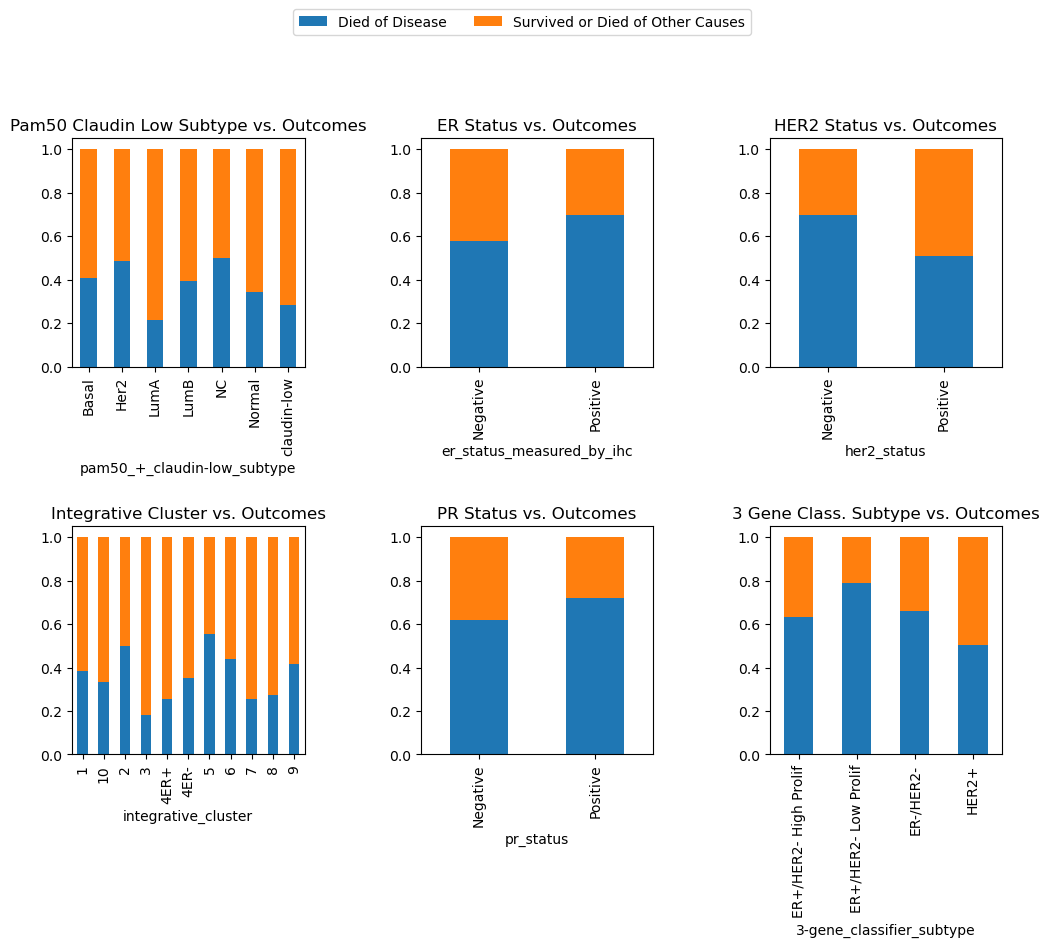

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
cancer_data.groupby('pam50_+_claudin-low_subtype')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0, 0])
ax[0, 0].set_title('Pam50 Claudin Low Subtype vs. Outcomes')

cancer_data.groupby('er_status_measured_by_ihc')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0, 1])
ax[0,1].set_title('ER Status vs. Outcomes')

cancer_data.groupby('her2_status')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0,2])
ax[0, 2].set_title('HER2 Status vs. Outcomes')


cancer_data.groupby('integrative_cluster')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1, 0])
ax[1, 0].set_title('Integrative Cluster vs. Outcomes')


cancer_data.groupby('pr_status')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1, 1])
ax[1, 1].set_title('PR Status vs. Outcomes')


cancer_data.groupby('3-gene_classifier_subtype')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1,2])
ax[1, 2].set_title('3 Gene Class. Subtype vs. Outcomes')

#Remove legends in subplots:
for a in ax.flat:
    if a.get_legend():
        a.get_legend().remove()

# common legend outside the subplots
handles, labels = ax[1, 0].get_legend_handles_labels()
fig.legend(handles,  ['Died of Disease', 'Survived or Died of Other Causes'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)


plt.subplots_adjust(wspace=0.5, hspace=.7)

plt.show();

### Observations of note:

Metaplastic breast cancer had the worst outcome

Neoplasm Histologic Grade shows a clear relationship with outcome; the lower the grade, the more patients who died of cancer. 
It looks like patients who did not die of cancer generally had fewer than 5 positive lymph nodes, and most had 0. Most of the patients with over 5 lymph nodes positive died of cancer. 

Negative ER status , negative PR status, and positive HER32 status were associated with better outcomes. 


## 2.5.4 Are there similar distributions in the data for the different cohorts? <a id='2.5.4_Cohorts'></a> 
I want to make sure that the cohorts have similar data distributions. I'm picking a few metrics that will give me an idea of the overall population. 

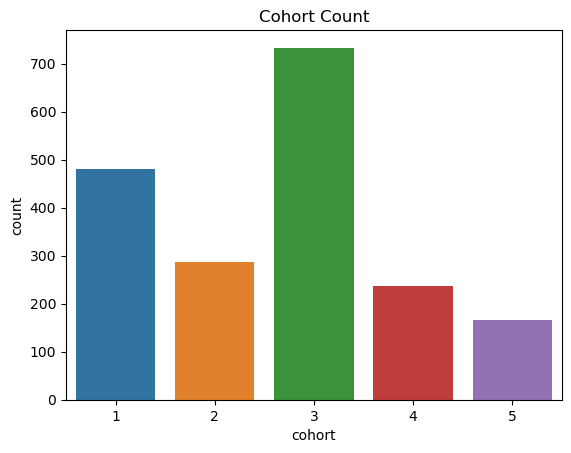

In [25]:
#looking at the overall counts for the different cohorts
sns.countplot(data=cancer_data,x='cohort')
plt.title('Cohort Count')
plt.show();

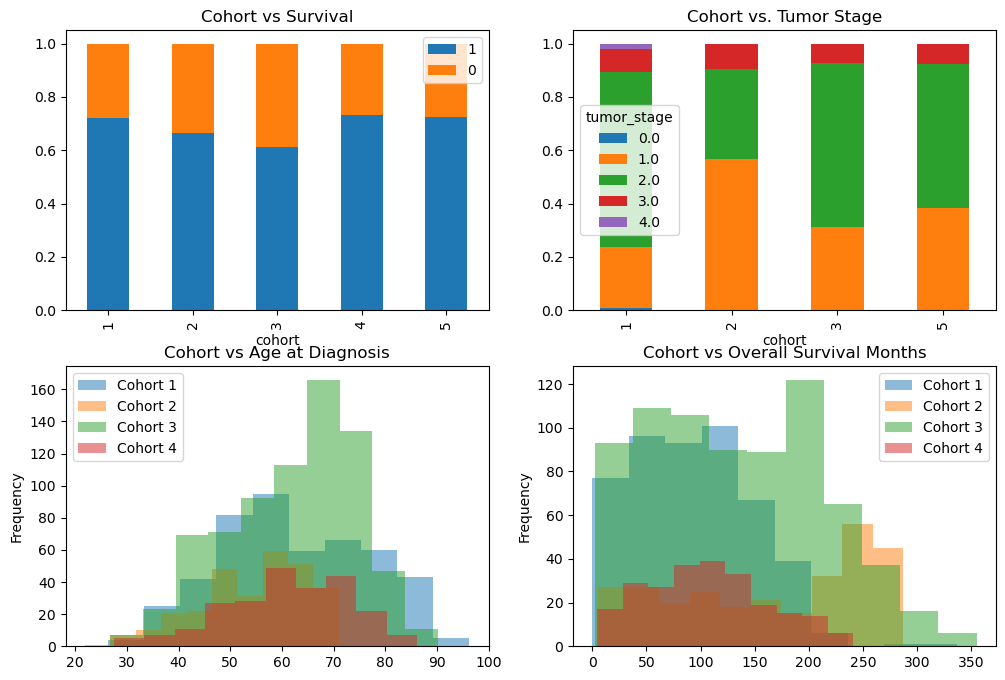

In [26]:
# plot of cohorts vs clinical attributes
fig, ax = plt.subplots(2,2, figsize=(12,8))
cancer_data.groupby('cohort')['death_from_cancer'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0, 0])
ax[0, 0].set_title('Cohort vs Survival')

cancer_data.groupby('cohort')['tumor_stage'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[0, 1])
ax[0, 1].set_title('Cohort vs. Tumor Stage')

#cancer_data.groupby('cohort')['tumor_size'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax[1,0])
#ax[1,0].set_title('Cohort vs Tumor Size')

cancer_data[cancer_data['cohort'] == 1]['age_at_diagnosis'].plot.hist(ax=ax[1, 0], alpha=0.5, stacked=True)
cancer_data[cancer_data['cohort'] == 2]['age_at_diagnosis'].plot.hist(ax=ax[1, 0], alpha=0.5, stacked=True)
cancer_data[cancer_data['cohort'] == 3]['age_at_diagnosis'].plot.hist(ax=ax[1, 0], alpha=0.5, stacked=True)
cancer_data[cancer_data['cohort'] == 4]['age_at_diagnosis'].plot.hist(ax=ax[1, 0], alpha=0.5, stacked=True)
ax[1, 0].set_title('Cohort vs Age at Diagnosis')
ax[1, 0].legend(['Cohort 1', 'Cohort 2', 'Cohort 3', 'Cohort 4'])

cancer_data[cancer_data['cohort'] == 1]['overall_survival_months'].plot.hist(ax=ax[1, 1], alpha=0.5, stacked=True)
cancer_data[cancer_data['cohort'] == 2]['overall_survival_months'].plot.hist(ax=ax[1, 1], alpha=0.5, stacked=True)
cancer_data[cancer_data['cohort'] == 3]['overall_survival_months'].plot.hist(ax=ax[1, 1], alpha=0.5, stacked=True)
cancer_data[cancer_data['cohort'] == 4]['overall_survival_months'].plot.hist(ax=ax[1, 1], alpha=0.5, stacked=True)
ax[1, 1].set_title('Cohort vs Overall Survival Months')
ax[1, 1].legend(['Cohort 1', 'Cohort 2', 'Cohort 3', 'Cohort 4'])

#plt.subplots_adjust(wspace=0.5, hspace=2.7)

plt.show();


In the above plots, cohort 3 seems to have a bit more death from disease, but they also have an overall older patient population, and above we saw that older patients are more likely to have poor outcomes. I also see that cohort 3 has the largest spread of survival months; however as this was the largest group it is not surprising. This is all consistent with what we've seen so far and I don't think we need to take into account the cohort, except with the missing stage data from cohort 4. 

## 2.5.5 Correlations Between Clinical Attributes   <a id='2.5.5_Attributes_Correlations'></a>

In [27]:
# Segment out the clinical attribute data from cancer_data and look at data types. 
clinical = cancer_data.iloc[:,1:31]

clinical.dtypes

age_at_diagnosis                   float64
type_of_breast_surgery            category
cancer_type                       category
cancer_type_detailed              category
cellularity                       category
chemotherapy                         int64
pam50_+_claudin-low_subtype       category
cohort                               int64
er_status_measured_by_ihc         category
er_status                         category
neoplasm_histologic_grade          float64
her2_status_measured_by_snp6      category
her2_status                       category
tumor_other_histologic_subtype    category
hormone_therapy                      int64
inferred_menopausal_state         category
integrative_cluster                 object
primary_tumor_laterality          category
lymph_nodes_examined_positive        int64
mutation_count                       int64
nottingham_prognostic_index        float64
oncotree_code                     category
overall_survival_months            float64
overall_sur

In [28]:
#add back in patient_id column
clinical=clinical.join(cancer_data['patient_id'],how='left')

#put patient_id at the beginning of the DF, moving it from the end:
clinical.insert(0, 'patient_id', clinical.pop('patient_id'))

In [29]:
# corr() cannot be done on objects, and some of our integers need to be converted to categories as they aren't continuous

clinical['chemotherapy']=clinical['chemotherapy'].astype('category')
clinical['cohort']=clinical['cohort'].astype('category')
clinical['radio_therapy']=clinical['radio_therapy'].astype('category')
clinical['neoplasm_histologic_grade']=clinical['neoplasm_histologic_grade'].astype('category')
clinical['overall_survival']=clinical['overall_survival'].astype('category')
clinical['tumor_stage']=clinical['tumor_stage'].astype('category')
clinical['hormone_therapy']=clinical['hormone_therapy'].astype('category')
#drp integrative_cluster as it is an object
clinical=clinical.drop(columns=['integrative_cluster'])

clinical.dtypes

patient_id                           int64
age_at_diagnosis                   float64
type_of_breast_surgery            category
cancer_type                       category
cancer_type_detailed              category
cellularity                       category
chemotherapy                      category
pam50_+_claudin-low_subtype       category
cohort                            category
er_status_measured_by_ihc         category
er_status                         category
neoplasm_histologic_grade         category
her2_status_measured_by_snp6      category
her2_status                       category
tumor_other_histologic_subtype    category
hormone_therapy                   category
inferred_menopausal_state         category
primary_tumor_laterality          category
lymph_nodes_examined_positive        int64
mutation_count                       int64
nottingham_prognostic_index        float64
oncotree_code                     category
overall_survival_months            float64
overall_sur

So that we can do imputation and corr(), we need to do one hot encoding on the categories:

In [30]:
# select the columns that are categories
clinical_cat = clinical.select_dtypes('category')
# make a list of the column labels
clinical_cat = clinical_cat.columns.values.tolist()
clinical_cat 


['type_of_breast_surgery',
 'cancer_type',
 'cancer_type_detailed',
 'cellularity',
 'chemotherapy',
 'pam50_+_claudin-low_subtype',
 'cohort',
 'er_status_measured_by_ihc',
 'er_status',
 'neoplasm_histologic_grade',
 'her2_status_measured_by_snp6',
 'her2_status',
 'tumor_other_histologic_subtype',
 'hormone_therapy',
 'inferred_menopausal_state',
 'primary_tumor_laterality',
 'oncotree_code',
 'overall_survival',
 'pr_status',
 'radio_therapy',
 '3-gene_classifier_subtype',
 'tumor_stage',
 'death_from_cancer']

In [31]:
# we also need the columns that are not categories
clinical_num = clinical.select_dtypes(['float64','int64'])
clinical_num.head()

patient_id  age_at_diagnosis  lymph_nodes_examined_positive  \
0           0             75.65                             10   
1           2             43.19                              0   
2           5             48.87                              1   
3           6             47.68                              3   
4           8             76.97                              8   

   mutation_count  nottingham_prognostic_index  overall_survival_months  \
0               0                        6.044                    140.5   
1               2                        4.020                     84.6   
2               2                        4.030                    163.7   
3               1                        4.050                    164.9   
4               2                        6.080                     41.4   

   tumor_size  
0        22.0  
1        10.0  
2        15.0  
3        25.0  
4        40.0

In [32]:
# One hot encoding to create separate columns for all the categories. Setting dummy_na=True so that I don't lose my missing data.
#clinical_dummies= pd.get_dummies(data=clinical,columns=clinical_cat,dummy_na=True)
clinical_dummies=pd.get_dummies(data=clinical, dummy_na=True)

clinical_dummies.head(10)

patient_id  age_at_diagnosis  lymph_nodes_examined_positive  \
0           0             75.65                             10   
1           2             43.19                              0   
2           5             48.87                              1   
3           6             47.68                              3   
4           8             76.97                              8   
5          10             78.77                              0   
6          14             56.45                              1   
7          22             89.08                              1   
8          28             86.41                              1   
9          35             84.22                              0   

   mutation_count  nottingham_prognostic_index  overall_survival_months  \
0               0                        6.044                    140.5   
1               2                        4.020                     84.6   
2               2                        4.030                    163.7   
3               1                        4.050                    164.9   
4               2                        6.080                     41.4   
5               4                        4.062                      7.8   
6               4                        4.020                    164.3   
7               1                        4.058                     99.5   
8               4                        5.032                     36.6   
9               5                        3.056                     36.3   

   tumor_size  type_of_breast_surgery_BREAST CONSERVING  \
0        22.0                                         0   
1        10.0                                         1   
2        15.0                                         0   
3        25.0                                         0   
4        40.0                                         0   
5        31.0                                         0   
6        10.0                                         1   
7        29.0                                         1   
8        16.0                                         1   
9        28.0                                         0   

   type_of_breast_surgery_MASTECTOMY  type_of_breast_surgery_nan  \
0                                  1                           0   
1                                  0                           0   
2                                  1                           0   
3                                  1                           0   
4                                  1                           0   
5                                  1                           0   
6                                  0                           0   
7                                  0                           0   
8                                  0                           0   
9                                  1                           0   

   cancer_type_Breast Cancer  cancer_type_Breast Sarcoma  cancer_type_nan  \
0                          1                           0                0   
1                          1                           0                0   
2                          1                           0                0   
3                          1                           0                0   
4                          1                           0                0   
5                          1                           0                0   
6                          1                           0                0   
7                          1                           0                0   
8                          1                           0                0   
9                          1                           0                0   

   cancer_type_detailed_Breast  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            0   

In [33]:
print('shape clinical_dummies:',clinical_dummies.shape)

shape clinical_dummies: (1903, 107)


In [34]:
# Find columns with all 0s
all_zero_cols = clinical_dummies.columns[(clinical_dummies == 0).all()]
print(all_zero_cols)

# Drop these columns
clinical_dummies.drop(columns=all_zero_cols, inplace=True)

Index(['cancer_type_nan', 'chemotherapy_nan',
       'pam50_+_claudin-low_subtype_nan', 'cohort_nan', 'er_status_nan',
       'her2_status_measured_by_snp6_nan', 'her2_status_nan',
       'hormone_therapy_nan', 'inferred_menopausal_state_nan',
       'overall_survival_nan', 'pr_status_nan', 'radio_therapy_nan',
       'death_from_cancer_nan'],
      dtype='object')


In [35]:
#list the column names
for col in clinical_dummies:
    print(col)

patient_id
age_at_diagnosis
lymph_nodes_examined_positive
mutation_count
nottingham_prognostic_index
overall_survival_months
tumor_size
type_of_breast_surgery_BREAST CONSERVING
type_of_breast_surgery_MASTECTOMY
type_of_breast_surgery_nan
cancer_type_Breast Cancer
cancer_type_Breast Sarcoma
cancer_type_detailed_Breast
cancer_type_detailed_Breast Invasive Ductal Carcinoma
cancer_type_detailed_Breast Invasive Lobular Carcinoma
cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma
cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma
cancer_type_detailed_Metaplastic Breast Cancer
cancer_type_detailed_nan
cellularity_High
cellularity_Low
cellularity_Moderate
cellularity_nan
chemotherapy_0
chemotherapy_1
pam50_+_claudin-low_subtype_Basal
pam50_+_claudin-low_subtype_Her2
pam50_+_claudin-low_subtype_LumA
pam50_+_claudin-low_subtype_LumB
pam50_+_claudin-low_subtype_NC
pam50_+_claudin-low_subtype_Normal
pam50_+_claudin-low_subtype_claudin-low
cohort_1
cohort_2
cohort_3
cohort_4


In [36]:
# Confirm that we have no more missing data
clinical_dummies.isna().sum().sort_values(ascending=False)

tumor_size                            20
patient_id                             0
tumor_other_histologic_subtype_nan     0
oncotree_code_IDC                      0
oncotree_code_BREAST                   0
                                      ..
pam50_+_claudin-low_subtype_Normal     0
pam50_+_claudin-low_subtype_NC         0
pam50_+_claudin-low_subtype_LumB       0
pam50_+_claudin-low_subtype_LumA       0
death_from_cancer_1                    0
Length: 94, dtype: int64

I'm still missing 20 tumor_size entries. 

I'm going to see if tumor_size is correlated with tumor_stage, but I'm going to use my clinical df, before I did get_dummies. As tumor_stage is categorical, I will find the correlation with Spearman's rank correlation. 

In [37]:
#First remove rows with missing tumor stage values
# Drop rows with missing values
clinical_dropped=clinical.dropna(subset=['tumor_size', 'tumor_stage'])


# Compute the Spearman's rank correlation coefficient between tumor_size and tumor_stage
corr, pval = spearmanr(clinical_dropped['tumor_size'], clinical_dropped['tumor_stage'])

# Print the correlation coefficient and p-value
print(f"Spearman's rank correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.4f}")

Spearman's rank correlation coefficient: 0.61
P-value: 0.0000


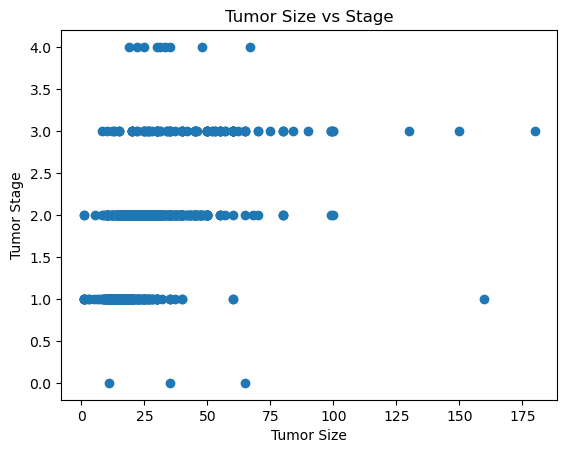

In [38]:
# plot tumor size vs stage
plt.scatter(clinical_dropped['tumor_size'], clinical_dropped['tumor_stage'])
plt.xlabel('Tumor Size')
plt.ylabel('Tumor Stage')
plt.title('Tumor Size vs Stage')
plt.show()

There is a reasonably good correlation between tumor size and stage. As there is a small number (20) of missing values compared to the size of the dataset, I think it's better to impute this than to drop those columns. I was not able to deal with them with the get_dummies as it's not categorical. I'm using the median of the stages to impute as there are outliers. 

### 2.5.5a Impute the missing tumor_size with median of the associated stage  <a id='2.5.5a_impute_tumor_size'></a>

In [39]:

# calculate the median tumor size for each tumor stage group
median_tumor_size = clinical.groupby('tumor_stage')['tumor_size'].median()
print(median_tumor_size)

tumor_stage
0.0    35.0
1.0    17.0
2.0    25.0
3.0    45.0
4.0    31.0
Name: tumor_size, dtype: float64


In [40]:
# find out if there are patients who have both of these columns missing data:

# count the number of rows where both tumor_size and tumor_stage are NaN
rows_with_both_nan = clinical[['tumor_size', 'tumor_stage']].isna().all(axis=1).sum()

print(rows_with_both_nan)

17


Unfortunately, most of the columns missing tumor_size are also missing tumor_stage.

In [41]:
#Impute the 3 rows that have both of these columns: 

# loop over the rows with missing tumor size values
for index, row in clinical[clinical['tumor_size'].isnull()].iterrows():
    # get the tumor stage for the current row
    stage = row['tumor_stage']
    
    # if the median tumor size for the stage is available, replace the missing value with the median
    if stage in median_tumor_size:
        clinical.at[index, 'tumor_size'] = median_tumor_size[stage]


# Patients still missing size data:
print(clinical['tumor_size'].isnull().sum())

17


In [42]:
# Now we'll just impute with the overall median for whether they died or not. 

outcome_size =clinical.groupby('death_from_cancer')['tumor_size'].median()
outcome_size
 

death_from_cancer
0    25.5
1    21.0
Name: tumor_size, dtype: float64

In [43]:
#Replace missing size values with the median size for their outcome group.

for index, row in clinical[clinical['tumor_size'].isnull()].iterrows():
    outcome = row['death_from_cancer']
    if outcome in median_tumor_size:
        clinical.at[index, 'tumor_size'] = median_tumor_size[outcome]

# check the number of missing tumor_size values after imputation
print(clinical['tumor_size'].isnull().sum())

0


In [44]:
# replace the tumor_size column in clinical_dummies:

clinical_dummies['tumor_size']=clinical['tumor_size']

clinical_dummies.isna().sum().sort_values(ascending=False)

patient_id                                            0
tumor_other_histologic_subtype_Tubular/ cribriform    0
oncotree_code_BREAST                                  0
primary_tumor_laterality_nan                          0
primary_tumor_laterality_Right                        0
                                                     ..
pam50_+_claudin-low_subtype_NC                        0
pam50_+_claudin-low_subtype_LumB                      0
pam50_+_claudin-low_subtype_LumA                      0
pam50_+_claudin-low_subtype_Her2                      0
death_from_cancer_1                                   0
Length: 94, dtype: int64

Horray! No more missing data in our clinical attributes!!!

## 2.5.6 Correlation Matrix <a id='2.5.6_correlation_matrix'></a>

In [45]:
# view correlation full matrix

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
corr_matrix = clinical_dummies.corr()
corr_matrix

patient_id  age_at_diagnosis  \
patient_id                       1.000000          0.030569   
age_at_diagnosis                 0.030569          1.000000   
lymph_nodes_examined_positive   -0.043272         -0.006832   
mutation_count                   0.282847          0.008795   
nottingham_prognostic_index     -0.047332         -0.088431   
...                                   ...               ...   
tumor_stage_3.0                 -0.099751         -0.006027   
tumor_stage_4.0                 -0.105462          0.026914   
tumor_stage_nan                  0.567040          0.064357   
death_from_cancer_0              0.028438         -0.033333   
death_from_cancer_1             -0.028438          0.033333   

                               lymph_nodes_examined_positive  mutation_count  \
patient_id                                         -0.043272        0.282847   
age_at_diagnosis                                   -0.006832        0.008795   
lymph_nodes_examined_positive                       1.000000       -0.051227   
mutation_count                                     -0.051227        1.000000   
nottingham_prognostic_index                         0.563121        0.001477   
...                                                      ...             ...   
tumor_stage_3.0                                     0.301971       -0.021679   
tumor_stage_4.0                                     0.088185       -0.000060   
tumor_stage_nan                                     0.043700        0.103004   
death_from_cancer_0                                 0.243305        0.017006   
death_from_cancer_1                                -0.243305       -0.017006   

                               nottingham_prognostic_index  \
patient_id                                       -0.047332   
age_at_diagnosis                                 -0.088431   
lymph_nodes_examined_positive                     0.563121   
mutation_count                                    0.001477   
nottingham_prognostic_index                       1.000000   
...                                                    ...   
tumor_stage_3.0                                   0.277669   
tumor_stage_4.0                                   0.042314   
tumor_stage_nan                                  -0.011531   
death_from_cancer_0                               0.269808   
death_from_cancer_1                              -0.269808   

                               overall_survival_months  tumor_size  \
patient_id                                    0.099354   -0.006803   
age_at_diagnosis                             -0.150105    0.045946   
lymph_nodes_examined_positive                -0.240082    0.265407   
mutation_count                                0.046380    0.017518   
nottingham_prognostic_index                  -0.242953    0.279818   
...                                                ...         ...   
tumor_stage_3.0                              -0.136750    0.368234   
tumor_stage_4.0                              -0.059273    0.037484   
tumor_stage_nan                              -0.055560    0.036616   
death_from_cancer_0                          -0.436920    0.182377   
death_from_cancer_1                           0.436920   -0.182377   

                               type_of_breast_surgery_BREAST CONSERVING  \
patient_id                                                     0.016833   
age_at_diagnosis                                              -0.119233   
lymph_nodes_examined_positive                                 -0.157052   
mutation_count                                                -0.015351   
nottingham_prognostic_index                                   -0.136627   
...                                                                 ...   
tumor_stage_3.0                                               -0.106249   
tumor_stage_4.0                                               -0.040182   
tumor_stage_nan                                     

This is a large matrix, and I'd like to print out the pairs that are significantly correlated.

In [46]:

abs_corr = clinical_dummies.corr().abs()

unstacked = abs_corr.unstack()
corr_pairs = unstacked.sort_values(kind="quicksort", ascending=False)

print(corr_pairs[(corr_pairs < 1.0) & (corr_pairs > 0.5)])

hormone_therapy_1                         hormone_therapy_0                           1.000000
hormone_therapy_0                         hormone_therapy_1                           1.000000
type_of_breast_surgery_BREAST CONSERVING  type_of_breast_surgery_MASTECTOMY           0.976240
type_of_breast_surgery_MASTECTOMY         type_of_breast_surgery_BREAST CONSERVING    0.976240
er_status_measured_by_ihc_Positive        er_status_measured_by_ihc_Negative          0.956879
                                                                                        ...   
chemotherapy_0                            er_status_measured_by_ihc_Positive          0.506783
er_status_measured_by_ihc_Positive        chemotherapy_1                              0.506783
chemotherapy_1                            er_status_measured_by_ihc_Positive          0.506783
er_status_measured_by_ihc_Negative        pam50_+_claudin-low_subtype_Basal           0.501942
pam50_+_claudin-low_subtype_Basal         er_statu

None of the more strong correlations tell us anything about survival. 

For death_by_cancer, I see a weak correlation (0.24) with the number of lymph nodes positive and similarly weak correlation (0.27) with the nottingham prognostic index. I don't see any other correlations that could mean anything for death_by_cancer.



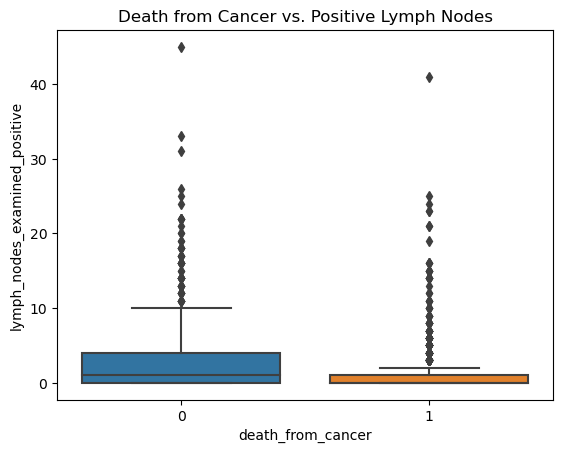

In [47]:
#looking at box plot of the outcome vs lympth nodes. I see that people who survived overall had fewer lymph nodes positive. 

_ = sns.boxplot(x='death_from_cancer',y='lymph_nodes_examined_positive',data=clinical).set(title='Death from Cancer vs. Positive Lymph Nodes')
plt.show;

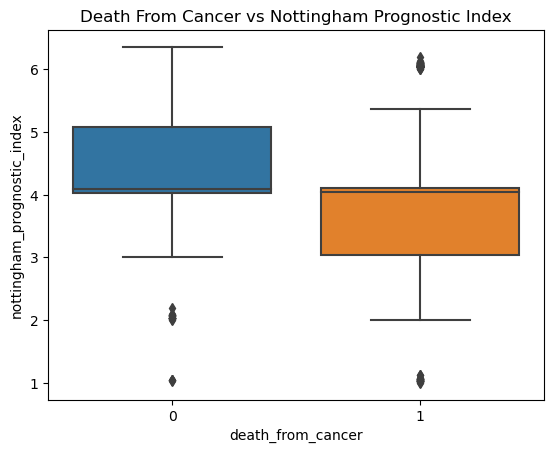

In [48]:
# looking at outcome vs the nottingham prognostic index. Here I see that most people who died have an index over 4,
#and most who survived had an index under 4, even though the median for the two groups was similar.

#THIS SEEMS TO BE OUR BEST INDICATOR SO FAR OF OUTCOME PREDICTION

_ = sns.boxplot(x='death_from_cancer',y='nottingham_prognostic_index',data=clinical).set(title='Death From Cancer vs Nottingham Prognostic Index')
plt.show;

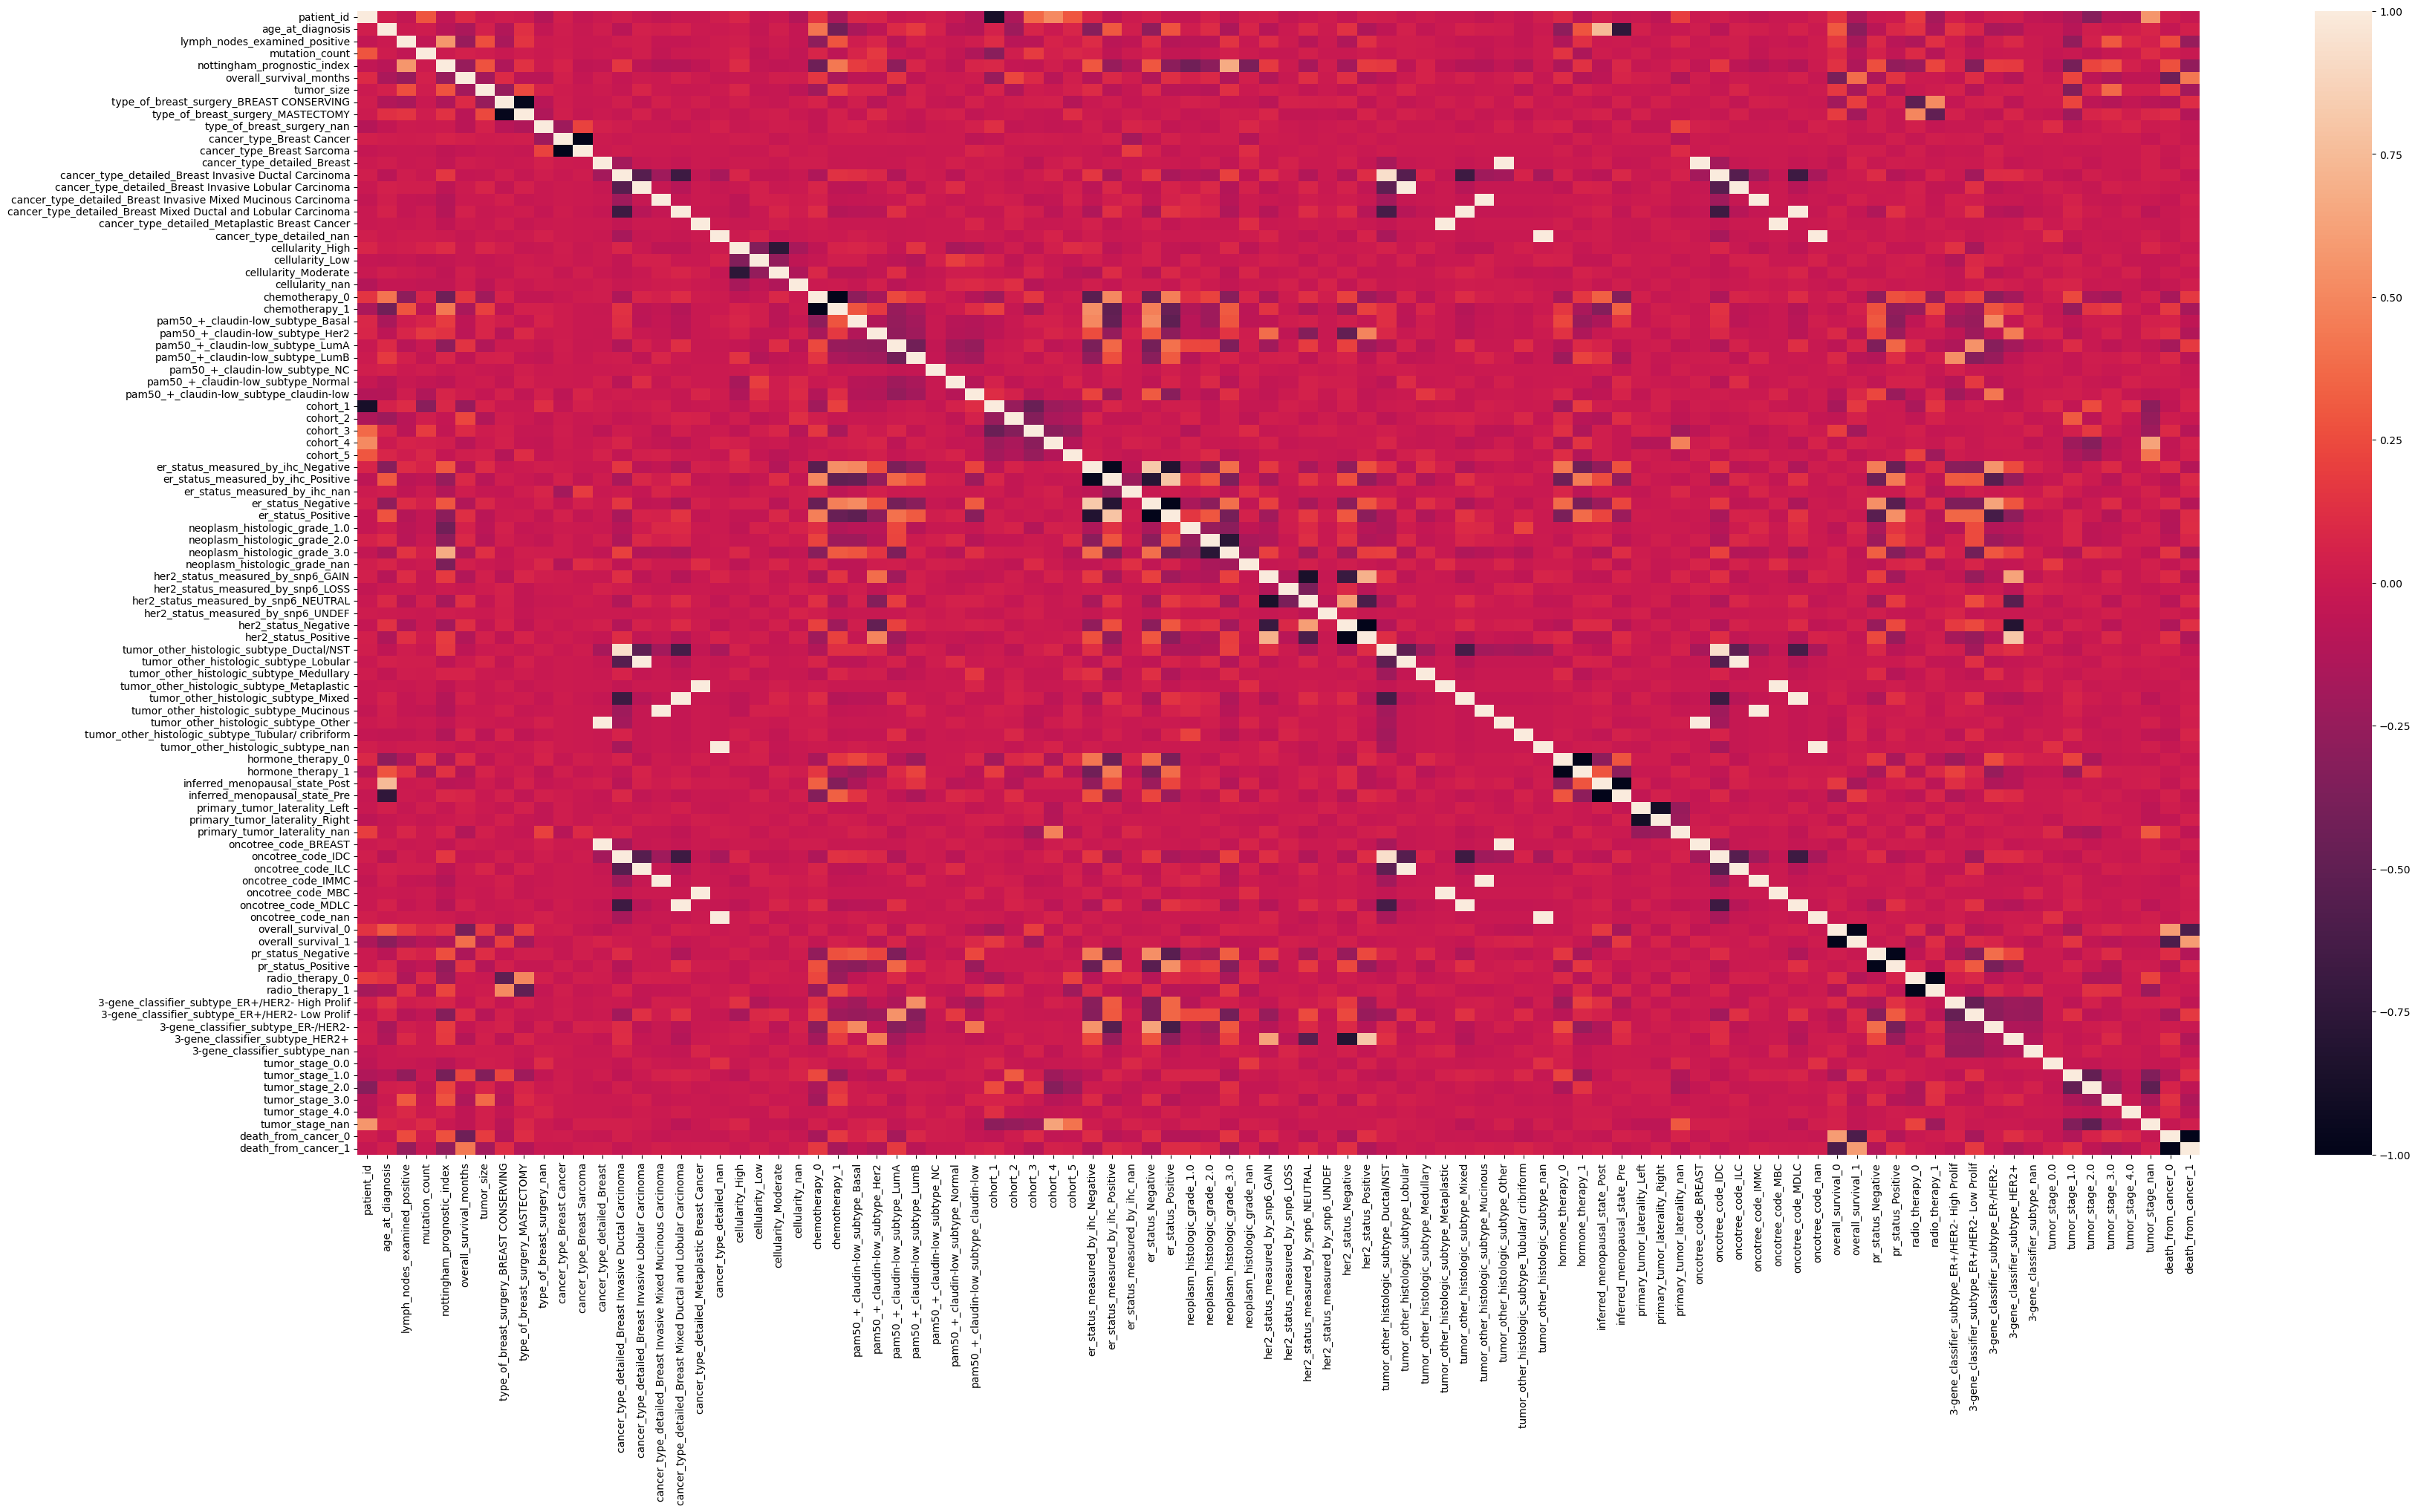

In [49]:
#make a heat map of correlations

plt.figure(figsize=(40,20))

sns.heatmap(clinical_dummies.corr(), annot=False);

## 2.6 Z Score Data  <a id='2.6_z_score'></a>

### 2.6.1 How are the z scores connected to the genetic mutation data? <a id='2.6.1_z_score_mutation'></a>

How do the z scores relate to the mutation section of our data? Are there corresponding mutations for the z score columns?

In [50]:
#extract z score columns:
z_scores=cancer_data.loc[:,'brca1':'ugt2b7']

#extract mutation columns:
mutation_cols = cancer_data.loc[:,'pik3ca_mut':]


In [51]:
#I want to find which genes are both in z_scores and mutation_cols.

z_mut_match=[]
# Iterate over the z-score column names
for col in z_scores:
    gene_name = col  # Assuming the gene name is the same as the z-score column name
    mutations = f"{gene_name}_mut"
    if mutations in mutation_cols.columns:
        z_mut_match.append(col)
        
print(z_mut_match)

['brca1', 'brca2', 'pten', 'tp53', 'cdh1', 'chek2', 'nf1', 'stk11', 'rb1', 'cdkn2a', 'cdkn1b', 'jak1', 'ep300', 'fbxw7', 'ncor2', 'notch1', 'acvrl1', 'akt1', 'akt2', 'atr', 'braf', 'casp8', 'egfr', 'erbb2', 'erbb3', 'erbb4', 'foxo1', 'foxo3', 'hras', 'kras', 'map2k4', 'map3k1', 'pik3ca', 'pik3r1', 'smad2', 'smad4', 'arid1a', 'arid1b', 'cbfb', 'gata3', 'kmt2c', 'kmt2d', 'myh9', 'ncor1', 'pde4dip', 'ptprd', 'ros1', 'runx1', 'tbx3', 'adgra2', 'afdn', 'aff2', 'agmo', 'agtr2', 'ahnak', 'ahnak2', 'akap9', 'alk', 'apc', 'arid2', 'arid5b', 'asxl1', 'asxl2', 'bap1', 'bcas3', 'birc6', 'cacna2d3', 'ccnd3', 'chd1', 'clk3', 'clrn2', 'col12a1', 'col22a1', 'col6a3', 'ctcf', 'ctnna1', 'ctnna3', 'dnah11', 'dnah2', 'dnah5', 'dtwd2', 'fam20c', 'fanca', 'fancd2', 'flt3', 'foxp1', 'frmd3', 'gh1', 'gldc', 'gpr32', 'gps2', 'hdac9', 'herc2', 'hist1h2bc', 'kdm3a', 'kdm6a', 'klrg1', 'l1cam', 'lama2', 'lamb3', 'large1', 'ldlrap1', 'lifr', 'lipi', 'magea8', 'map3k10', 'map3k13', 'men1', 'mtap', 'muc16', 'myo1a', 

In [52]:
print('number of columns in z_scores: ',z_scores.shape[1])
print('number of columns in mutation_cols: ',mutation_cols.shape[1])
print('number of matches between z scores and mutations: ',len(z_mut_match))
print('percent of z_scores with corresponding mutation: ',len(z_mut_match)/z_scores.shape[1]*100,'%')

print('number of z scores that do not have a match: ',489-len(z_mut_match))
print('number of mutations that do not have a match: ',173-len(z_mut_match))

number of columns in z_scores:  489
number of columns in mutation_cols:  173
number of matches between z scores and mutations:  168
percent of z_scores with corresponding mutation:  34.355828220858896 %
number of z scores that do not have a match:  321
number of mutations that do not have a match:  5


### Conclusion:

Only about 34% of the z_score columns have a corresponding column for mutations, but all but 5 of the mutation columns have a matching z_score. However, we should still look at all of the z scores and all of the mutations because the fact that a gene is up-regulated or down-regulated may potentially have an impact on survival. I don't think I should try to tie the z scores and genes together in the data, I'll leave it as it is. 



## 2.6.2 Z Score Outcomes <a id='2.6.2_z_score_outcomes'></a>
Here I am investigating our z scores, and will see how they are related to patient outcomes.

### 2.6.2a Z Score Distributions  <a id='2.6.2a_z_score_dist'></a>

In [53]:
#create dataframe of just z_scores
z_scores = cancer_data.iloc[:,32:520]
z_scores.head()

brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1  \
0 -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348  0.1266 -0.8361 -0.8578   
1  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059   
2 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305   
3 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165   
4 -0.9039 -0.7219  0.2168  0.3484  0.3897  0.9131  0.9356  0.7675 -0.2940   

    stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d  \
0 -0.4294 -1.1201 -0.4844 -0.7483 -1.6660 -0.1250 -0.3721 -0.6508 -0.1278   
1  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909   
2  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421   
3  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161 -0.3098 -1.3470   
4 -0.2961  0.6320 -0.3582  0.3032  0.8747  0.6323  0.3349 -0.2652 -0.1541   

    rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  \
0  1.7330 -0.2770 -1.0673  0.0615  0.1034 -1.6635 -2.0649 -1.3388 -0.6208   
1  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813   
2  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109   
3  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801  0.0476 -0.6651 -1.4457   
4 -0.7631  1.0158  1.8996  0.6618 -0.7454  0.2862  1.1035 -1.0514  1.5423   

   cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  \
0 -1.7309 -0.8059 -1.1037  0.0744  1.4313 -0.5785  1.2180  2.5602  2.3152   
1 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389   
2 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829   
3 -0.3827 -0.4537 -1.5248  0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119   
4  1.2169  0.1169  1.7648  0.8892 -1.0195  0.3664  0.7145  0.5223  1.5638   

   cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8  \
0 -0.2487  0.1601 -1.8799 -1.3629  0.1992 -0.0907 -0.1167 -1.3917 -0.8178   
1  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693   
2  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908   
3  3.4617  0.4610 -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409   
4  0.1562 -0.2666  0.4509 -0.4449 -0.3181  2.2129  1.1063 -0.0650  1.4216   

      src    jak1    jak2   stat1   stat2   stat3  stat5a  stat5b    mdm2  \
0 -1.0737  1.1097  1.6186  0.0413 -0.7556  0.9765  3.9189  2.5773  0.3126   
1 -0.3297  0.9804 -0.0104 -1.1940 -0.7991 -0.8428 -0.4983 -1.3251  0.8803   
2 -0.7181  1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832 -0.8822   
3 -0.3804  0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195  0.2551   
4  0.9720  0.0461  0.1645  0.2677  0.3308 -0.5049 -0.3295 -0.4278 -0.0063   

   tp53bp1  adam10  adam17   aph1a   aph1b  arrdc1    cir1   ctbp1   ctbp2  \
0  -0.6271 -0.5319  0.8721  0.0020 -0.0098 -1.4652 -0.2752 -1.1021  0.8414   
1  -1.5924 -1.2672 -0.2006  1.3135  0.6880  1.3366  1.5911  1.1926  0.3010   
2   0.7590  2.0364 -1.1229  3.1331 -0.4959 -1.0596  1.6744 -2.2695  0.2397   
3  -1.0064  1.4659 -1.0490  2.3645 -1.2458  1.4919  2.6438 -0.7268 -0.4622   
4   0.1063  0.9378 -0.2383  0.1228  0.3690  0.9222  0.2017 -0.8767  1.8501   

     cul1    dll1    dll3    dll4    dtx1    dtx2    dtx3    dtx4   ep300  \
0  0.4469  0.6307 -0.5067  1.6931  1.7100 -1.8994  0.6028  0.3299  1.5090   
1 -0.4113 -1.5476 -0.1581 -0.1005 -0.9584 -0.1775 -0.7991 -0.3891 -0.4294   
2  0.1616 -1.0439  0.9493 -1.7455 -0.8876  0.2312 -1.2906  1.1141 -1.5670   
3  0.1933  0.4481  1.6109 -0.5916 -0.4730 -0.2765 -1.1845  1.1098 -1.7947   
4 -0.6839 -1.2165 -0.8212  0.2763  0.1702 -0.7525 -2.4018  0.3444 -0.5688   

    fbxw7   hdac1   hdac2    hes1    hes5    heyl    itch    jag1    jag2  \
0  0.3038 -1.6822  0.1622  0.8322  0.9870 -1.9028 -0.4093 -0.0858  0.2445   
1  0.6385  1.6267 -0.9130  0.2582  0.0066 -0.5588  0.7234  0.2604 -0.6473   
2 -1.6157 -1.8103  0.8620  1.1837 -0.1830 -0.4287  0.0269  0.98

In [54]:
#create one with patient IDs and outcome as well:

patient_id = cancer_data['patient_id']
outcome = cancer_data['death_from_cancer']
z_scores_id = pd.concat([patient_id, outcome, z_scores], axis=1)
z_scores_id.set_index('patient_id', inplace=True)

z_scores_id.head()

death_from_cancer   brca2   palb2    pten    tp53     atm    cdh1  \
patient_id                                                                     
0                          1 -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348   
2                          1  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594   
5                          0 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398   
6                          1 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491   
8                          0 -0.9039 -0.7219  0.2168  0.3484  0.3897  0.9131   

             chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6  \
patient_id                                                                   
0           0.1266 -0.8361 -0.8578 -0.4294 -1.1201 -0.4844 -0.7483 -1.6660   
2           0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821   
5           0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608   
6          -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615   
8           0.9356  0.7675 -0.2940 -0.2961  0.6320 -0.3582  0.3032  0.8747   

              pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2  \
patient_id                                                                   
0          -0.1250 -0.3721 -0.6508 -0.1278  1.7330 -0.2770 -1.0673  0.0615   
2           1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835   
5           2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662   
6           2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279   
8           0.6323  0.3349 -0.2652 -0.1541 -0.7631  1.0158  1.8996  0.6618   

             ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4  \
patient_id                                                                   
0           0.1034 -1.6635 -2.0649 -1.3388 -0.6208 -1.7309 -0.8059 -1.1037   
2          -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108   
5          -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312   
6           0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248   
8          -0.7454  0.2862  1.1035 -1.0514  1.5423  1.2169  0.1169  1.7648   

              cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1  \
patient_id                                                                   
0           0.0744  1.4313 -0.5785  1.2180  2.5602  2.3152 -0.2487  0.1601   
2          -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984   
5           0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248   
6           0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610   
8           0.8892 -1.0195  0.3664  0.7145  0.5223  1.5638  0.1562 -0.2666   

              e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src  \
patient_id                                                                   
0          -1.8799 -1.3629  0.1992 -0.0907 -0.1167 -1.3917 -0.8178 -1.0737   
2          -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297   
5          -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181   
6          -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804   
8           0.4509 -0.4449 -0.3181  2.2129  1.1063 -0.0650  1.4216  0.9720   

              jak1    jak2   stat1   stat2   stat3  stat5a  stat5b    mdm2  \
patient_id                                                                   
0           1.1097  1.6186  0.0413 -0.7556  0.9765  3.9189  2.5773  0.3126   
2           0.9804 -0.0104 -1.1940 -0.7991 -0.8428 -0.4983 -1.3251  0.8803   
5           1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832 -0.8822   
6           0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195  0.2551   
8           0.0461  0.1645  0.2677  0.3308 -0.5049 -0.3295 -0.4278 -0.0063   

            tp53bp1  adam10  adam17   aph1a   aph1b  arrdc1    cir1   ctbp1  \
patient_id                                                                    
0         

In [55]:
z_scores.describe()

brca2        palb2         pten         tp53          atm  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.001073    -0.001062    -0.000312    -0.000356     0.001180   
std       0.999428     0.999451     1.000433     1.000404     0.999198   
min      -2.783500    -4.384600    -5.932800    -2.481200    -3.170500   
25%      -0.698550    -0.680250    -0.558900    -0.666200    -0.658250   
50%      -0.057800    -0.023900     0.108700    -0.035200    -0.003200   
75%       0.629000     0.638400     0.642750     0.643050     0.690400   
max       3.737900     4.615000     3.254100     4.289800     3.824200   

              cdh1        chek2          nbn          nf1        stk11  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.000214    -0.000290    -0.000263     0.000074     0.000463   
std       1.000483     1.000445     1.000460     1.000519     1.000321   
min      -3.323700    -2.688700    -3.689800    -2.968600    -3.060200   
25%      -0.459000    -0.738900    -0.667050    -0.684050    -0.681750   
50%       0.115800    -0.131600    -0.014900    -0.053700    -0.057200   
75%       0.650100     0.539600     0.639450     0.669450     0.536450   
max       2.820900     4.538200     5.371300     6.178600     4.850100   

             bard1         mlh1         msh2         msh6         pms2  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean     -0.000245     0.000927    -0.000226    -0.000621    -0.000145   
std       1.000468     0.999706     1.000476     1.000158     1.000507   
min      -2.984900    -6.438700    -2.074000    -4.055600    -3.032000   
25%      -0.687150    -0.567200    -0.613950    -0.675150    -0.664950   
50%      -0.032600     0.098500    -0.128900    -0.103600    -0.030800   
75%       0.664400     0.654650     0.411600     0.558500     0.586000   
max       3.364600     3.293500     9.586400     5.402800     6.223100   

             epcam       rad51c       rad51d        rad50          rb1  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean     -0.000107     0.000792     0.000544    -0.000785     0.000242   
std       1.000515     0.999933     1.000243     0.999942     1.000469   
min      -2.165900    -3.256700    -2.964300    -3.385400    -2.730900   
25%      -0.686300    -0.615250    -0.620450    -0.648550    -0.627950   
50%      -0.150700    -0.133300    -0.106600    -0.005600     0.036200   
75%       0.525500     0.494050     0.497200     0.648000     0.654950   
max       6.953900     4.405400     9.523300     5.166800     3.406900   

              rbl1         rbl2        ccna1        ccnb1         cdk1  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean     -0.000290     0.000153     0.000479     0.000164    -0.000123   
std       1.000446     1.000503     1.000307     1.000501     1.000511   
min      -2.746500    -4.662100    -1.445600    -2.213500    -2.403500   
25%      -0.687000    -0.593050    -0.470800    -0.727600    -0.734100   
50%      -0.143300    -0.021300    -0.211300    -0.087700    -0.033400   
75%       0.493050     0.582750     0.101150     0.605550     0.654400   
max       5.047100     5.465900    10.613500     4.556000     4.613400   

             ccne1         cdk2       cdc25a        ccnd1         cdk4  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.000428    -0.000431     0.000594    -0.000431    -0.000164   
std       1.000351     1.000349     1.000189     1.000348     1.000500   
min      -1.547000    -4.217000    -1.950700    -4.077800    -4.524700   
25%      -0.678000    -0.668700    -0.712450    -0.588250    -0.594750   
50%      -0.280500    -0.088800    -0.215000     0.031900    -0.101600   
75%       0.370450     0.604000     0.505550     0.668250     0.474850   
max       5.644100     5.591600     4.499200     2.356500     8.312600   

           

In [56]:
z_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Columns: 488 entries, brca2 to ugt2b7
dtypes: float64(488)
memory usage: 7.1 MB


In [57]:
#find maximum z scores
max_z = z_scores.max().sort_values(ascending=False)
max_z.head(20)

cyp3a7     20.3950
lipi       20.1984
tubb4a     18.6351
hes5       17.1431
nrg3       16.4499
itgb3      15.3308
ush2a      15.3011
dnah11     15.1319
gh1        14.9228
slco1b3    14.8651
inha       14.4243
bmp3       13.6356
star       12.7423
agmo       12.7286
magea8     12.6817
ugt2b17    12.6439
hsd3b1     12.4827
folr3      12.1739
myo3a      12.1496
aff2       12.1414
dtype: float64

In [58]:
#minimum z scores

min_z = z_scores.min().sort_values(ascending=True)
min_z.head(20)

smarcd1    -7.2432
mlh1       -6.4387
rab25      -6.3503
ctnna1     -6.1880
hdac1      -5.9821
spen       -5.9510
pten       -5.9328
foxo3      -5.7543
bap1       -5.5759
hsd17b12   -5.5031
ctcf       -5.4334
acvr1b     -5.4165
usp9x      -5.3370
palld      -5.3133
erbb3      -5.2830
asxl2      -5.2613
ahnak      -5.1982
rheb       -5.1559
col6a3     -5.1480
numb       -5.1235
dtype: float64

I see that our z scores go between about -7 and 20, but where do most of the z scores fall?

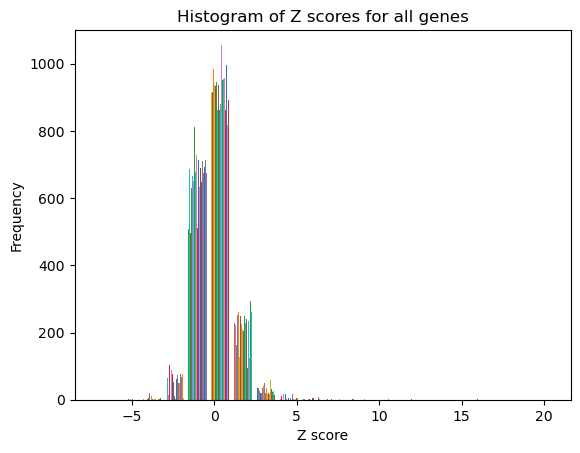

In [59]:
# create a list of gene names to plot
genes_to_plot = z_scores.columns.to_list()

# create a list to hold the z scores for each gene
z_score_lists = []

# loop through each gene in genes_to_plot and add its z scores to the list
for gene in genes_to_plot:
    z_score_lists.append(z_scores[gene])

# plot the histograms for each gene on the same plot
plt.hist(z_score_lists, bins=20, label=genes_to_plot)

plt.xlabel('Z score')
plt.ylabel('Frequency')
plt.title('Histogram of Z scores for all genes')
plt.ylim(0,1100)

plt.show()

The above plot covers the range of all of the data, but the vast majority of our data is between -5 and 5. I want to zoom in here. 

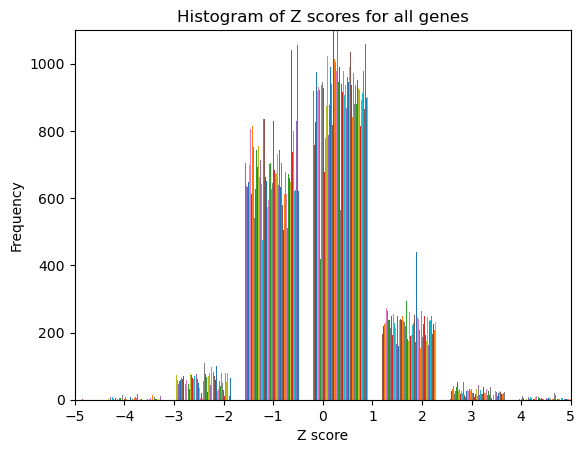

In [60]:
# Repeating the previous code block, but zoomed in to -5 to 5

for gene in genes_to_plot:
    z_score_lists.append(z_scores[gene])

plt.hist(z_score_lists, bins=20, label=genes_to_plot)

plt.xlabel('Z score')
plt.ylabel('Frequency')
plt.title('Histogram of Z scores for all genes')
plt.ylim(0,1100)
plt.xlim(-5,5)
plt.xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])

plt.show()

I see that the vast majority of our z scores fall between -3 and 4, and mostly beween -2 and 2. I would like to see if certain ranges of z scores are related to survival, as I suspect that the extreme z scores may be important.

In [61]:
#Z SCORES OVER 4
# Create a boolean mask based on the condition z_scores over 4
mask = (z_scores_id.iloc[:, 2:] >= 4).any(axis=1)

# Apply the boolean mask to filter the rows
z_score_over_4 = z_scores_id.loc[mask]

#Z SCORES UNDER =4

mask2 = (z_scores_id.iloc[:, 2:] <= -4).any(axis=1)

# Apply the boolean mask to filter the rows
z_score_under_neg_4  = z_scores_id.loc[mask2]

z_score_under_neg_4.head()

death_from_cancer   brca2   palb2    pten    tp53     atm    cdh1  \
patient_id                                                                     
39                         1  2.9681 -1.3904  1.4090 -1.9730 -0.1959  0.0172   
48                         1  0.5787 -1.3424  2.1343  0.4979  0.6301 -0.9512   
53                         1  1.7552  2.0942  0.8322 -0.7186 -0.5228 -0.1487   
54                         1  0.3484 -1.8203  0.8249 -2.1084 -0.5631 -0.0892   
56                         1  1.4181 -0.2651  1.1242 -0.8776  1.1415 -0.5771   

             chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6  \
patient_id                                                                   
39          0.4615  1.0712 -1.2031 -1.1680  0.7626  0.0997  6.1123  2.3953   
48          0.1415  0.7255 -0.7999 -0.6522  0.8348 -0.8235  4.3875  1.7485   
53          1.7892 -0.1382 -1.7195  0.0271  0.3755 -1.9739  4.5337 -0.1136   
54          1.1035  4.6654 -1.5942 -1.2718  0.5836 -2.8276  6.7606  1.7130   
56          1.5014  0.3745 -2.6661 -0.3066 -0.7330 -0.5379  6.5669  0.9122   

              pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2  \
patient_id                                                                   
39          1.2475  6.3889  4.3801  0.7881 -1.5922  0.0690 -0.1000  0.2636   
48          2.4637  3.8054  0.7119 -1.3563 -0.3438  1.8647 -0.5363  0.2980   
53          2.2238  2.8255  1.6467 -1.2785 -0.3193  2.4262 -0.9712 -0.2801   
54          3.4978  4.3459  1.7830 -1.0861  1.0033  0.9748 -1.1141 -0.1103   
56          3.0749  4.6391  1.7305  0.7427 -0.4142  2.4019 -1.3203  0.1260   

             ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4  \
patient_id                                                                   
39         -1.0543  0.6778  1.3954  0.2016 -1.3131  2.2853  0.6506  0.0829   
48         -0.1424  1.5120  1.3247 -0.6669 -1.2249 -0.2943 -1.4068 -0.3337   
53         -0.5917  2.2330  3.0471 -0.9368 -0.7124 -0.3580 -0.2012 -0.3926   
54         -0.5143  1.9237  2.2760  0.1581 -0.3278 -0.4820 -1.0627 -0.5281   
56         -0.4318  2.9726  3.1921 -0.0420  0.0700  0.0773 -0.8664  0.2574   

              cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1  \
patient_id                                                                   
39         -1.8089 -2.2276  0.2189 -1.1040 -1.5453 -0.3239  3.9828  1.8941   
48          0.2285  1.1581 -0.8144  0.6565 -0.9069 -0.1471  3.3015  0.9125   
53         -0.8368 -0.3570  0.9665  0.4138 -1.1888  0.6506  1.1488  2.0591   
54         -0.7720  0.1764  0.7482 -0.0873  0.2215  0.2247  3.0418  0.1281   
56         -1.2463 -0.4772 -0.3596 -0.1589 -0.3664 -0.0204  3.1225  1.3514   

              e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src  \
patient_id                                                                   
39         -0.4857 -0.9336 -2.7194 -0.3424  0.1572 -1.1007 -1.1040 -0.7471   
48         -1.4344  0.7199 -1.1746 -0.0901  0.4583 -0.4678 -0.6671 -1.0905   
53         -1.1300  0.0046 -1.1654  1.3086  1.6130 -0.9230 -0.1935 -1.8816   
54         -1.2300  1.5181 -2.4845  0.9259 -1.2295  0.0188 -0.6269 -1.1006   
56         -1.2103 -1.0828 -1.1325  1.0261 -0.6080 -0.0643  0.0800 -0.9624   

              jak1    jak2   stat1   stat2   stat3  stat5a  stat5b    mdm2  \
patient_id                                                                   
39         -0.6508  0.6033  0.7866 -2.2668 -3.4859 -0.9569  0.5111 -1.1877   
48          1.0635  2.9301  1.2924  0.3139 -2.8034 -0.3026 -0.8709 -0.5403   
53          1.1148  1.7570 -0.0141 -2.1679 -2.9206 -0.4108 -0.6112  0.4498   
54          0.1041  2.2578  1.0235 -1.0025 -2.4194  0.1564 -0.1676 -1.5067   
56          0.9397  1.4227 -1.5790 -3.4368 -1.9874 -0.4850  0.0819 -1.4778   

            tp53bp1  adam10  adam17   aph1a   aph1b  arrdc1    cir1   ctbp1  \
patient_id                                                                    
39        

In [62]:
z_score_over_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 7298
Columns: 489 entries, death_from_cancer to ugt2b7
dtypes: category(1), float64(488)
memory usage: 3.7 MB


In [63]:
z_score_over_4.shape

(994, 489)

In [64]:
z_score_under_neg_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 39 to 7195
Columns: 489 entries, death_from_cancer to ugt2b7
dtypes: category(1), float64(488)
memory usage: 397.5 KB


In [65]:
z_score_under_neg_4.shape

(104, 489)

In [66]:
print('Number of patients with z scores over 4: ',z_score_over_4.shape[0])
print('Number of patients with z scores under -4: ',z_score_under_neg_4.shape[0])

Number of patients with z scores over 4:  994
Number of patients with z scores under -4:  104


It looks like 52% of our patients have at least 1 z score over 4, but only 5.5% have a z score under -4. Let's investigate this further to see how it may relate to outcome.

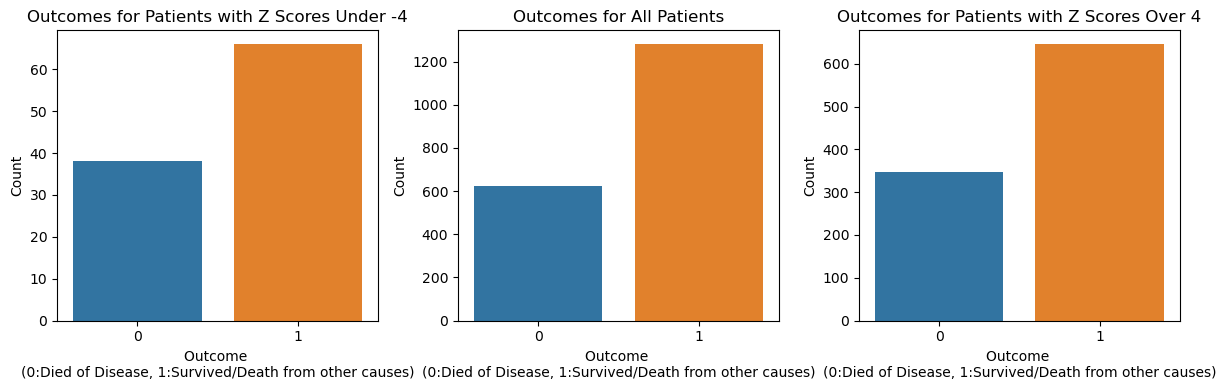

In [67]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# z scores under -4
sns.countplot(x='death_from_cancer', data=z_score_under_neg_4, ax=axes[0])
axes[0].set_xlabel('Outcome \n(0:Died of Disease, 1:Survived/Death from other causes)')
axes[0].set_ylabel('Count')
axes[0].set_title('Outcomes for Patients with Z Scores Under -4')

# full z scores
sns.countplot(x='death_from_cancer', data=z_scores_id, ax=axes[1])
axes[1].set_xlabel('Outcome \n(0:Died of Disease, 1:Survived/Death from other causes)')
axes[1].set_ylabel('Count')
axes[1].set_title('Outcomes for All Patients')

# z scores over 4
sns.countplot(x='death_from_cancer', data=z_score_over_4, ax=axes[2])
axes[2].set_xlabel('Outcome \n(0:Died of Disease, 1:Survived/Death from other causes)')
axes[2].set_ylabel('Count')
axes[2].set_title('Outcomes for Patients with Z Scores Over 4')

# Add spacing between subplots
fig.tight_layout()

# Show the plot
plt.show();


Below are printouts of the percents and counts for these three groups:

In [68]:
# z scores under -4
survival_counts1 =z_score_under_neg_4['death_from_cancer'].value_counts()
print('Low Z Score: Percents Died vs Survived:\n',100*survival_counts1/len(z_score_under_neg_4))
print('\nLow Z Scores Counts:\n ',survival_counts1)

survival_counts2 = cancer_data['death_from_cancer'].value_counts()
print('\nAll Patients: Percents Died vs Survived:\n',100*survival_counts2/len(cancer_data))
print('\nAll Z Scores Counts:\n ',survival_counts2)

survival_counts3 =z_score_over_4['death_from_cancer'].value_counts()
print('\nHigh Z Score: Percents Died vs Survived:\n',100*survival_counts3/len(z_score_over_4))
print('\nAll Z Scores Counts:\n ',survival_counts3)

Low Z Score: Percents Died vs Survived:
 1    63.461538
0    36.538462
Name: death_from_cancer, dtype: float64

Low Z Scores Counts:
  1    66
0    38
Name: death_from_cancer, dtype: int64

All Patients: Percents Died vs Survived:
 1    67.314766
0    32.685234
Name: death_from_cancer, dtype: float64

All Z Scores Counts:
  1    1281
0     622
Name: death_from_cancer, dtype: int64

High Z Score: Percents Died vs Survived:
 1    64.98994
0    35.01006
Name: death_from_cancer, dtype: float64

All Z Scores Counts:
  1    646
0    348
Name: death_from_cancer, dtype: int64


I can see tht 32.7% of all patients died from cancer, 36.5% for those with at least 1 z score under -4, and 35% of those with at least 1 z score over 4. 

However, our patient count is much lower for those with the low z scores. Is the change in proportion due to chance or is it significant? 

I will test our null hypothesis, which is that the z score makes no difference in patient outcome. As our outcome data is binary I should do a chi-squared test, but because our under -4 dataset only has 104 patients, I will also do a Fisher's Exact test. I'll do both to compare, but will rely more heavily on Fisher's Exact test. 

### 2.6.2b P-Values for Z Scores <a id='2.6.2a_p_values'></a>

Create Contingency Tables:

In [69]:
# contingency table for z_score_over_4 data:

table_fisher_4 = pd.DataFrame({'Z Score over 4':[348,646 ], 'All Z Scores':[622,1281]},index=pd.Index(['Died of Disease', 'Did Not Die of Disease']))
table_fisher_4

Z Score over 4  All Z Scores
Died of Disease                    348           622
Did Not Die of Disease             646          1281

In [70]:
# contingency table for z_score_under_neg_4 data:

table_fisher_neg_4 = pd.DataFrame({'Z Score Under -4':[38,66 ], 'All Z Scores':[622,1281]},index=pd.Index(['Died of Disease', 'Did Not Die of Disease']))
table_fisher_neg_4

Z Score Under -4  All Z Scores
Died of Disease                       38           622
Did Not Die of Disease                66          1281

### P-Value for Z scores Under -4

In [71]:
# Fisher's Exact Test (following this method: https://www.reneshbedre.com/blog/fisher-exact-test-python.html)
oddsr, p = fisher_exact(table=table_fisher_neg_4.to_numpy(), alternative='greater')
oddsr, p
print(f"Odds ratio: {oddsr:.2f}")
print(f"P-value: {p:.2e}")

Odds ratio: 1.19
P-value: 2.38e-01


In [72]:
# Chi Squared Test, to see how it compares:

chi2, p, dof, expected = chi2_contingency(table_fisher_neg_4)
print('Chi-squared statistic:', chi2)
print('P-value:', p)

Chi-squared statistic: 0.5002736717591013
P-value: 0.47937989787501756


### P-Value for Z scores Over 4

In [73]:
# Fisher's Exact Test (following this method: https://www.reneshbedre.com/blog/fisher-exact-test-python.html)
oddsr, p = fisher_exact(table=table_fisher_4.to_numpy(), alternative='greater')
oddsr, p
print(f"Odds ratio: {oddsr:.2f}")
print(f"P-value: {p:.2e}")

Odds ratio: 1.11
P-value: 1.12e-01


In [74]:
# Chi Squared Test, to see how it compares:

chi2, p, dof, expected = chi2_contingency(table_fisher_4)
print('Chi-squared statistic:', chi2)
print('P-value:', p)

Chi-squared statistic: 1.4818682056702317
P-value: 0.22348245281465767


### Observations:
The p values for extreme z scores are not small enough to reject the null hypothesis. So we cannot say that z scores impact survival outcomes.  


## 2.6.3 Correlation of Z Scores and Outcome <a id='2.6.3_corr'></a>

In [75]:
z_score_over_4.head()

death_from_cancer   brca2   palb2    pten    tp53     atm    cdh1  \
patient_id                                                                     
0                          1 -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348   
5                          0 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398   
6                          1 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491   
8                          0 -0.9039 -0.7219  0.2168  0.3484  0.3897  0.9131   
10                         0  0.6931  0.6909  1.0840 -1.9371  0.9252  1.1520   

             chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6  \
patient_id                                                                   
0           0.1266 -0.8361 -0.8578 -0.4294 -1.1201 -0.4844 -0.7483 -1.6660   
5           0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608   
6          -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615   
8           0.9356  0.7675 -0.2940 -0.2961  0.6320 -0.3582  0.3032  0.8747   
10          0.7951 -0.9677 -0.7750 -0.3532  1.0599 -0.2754  0.5496  1.1321   

              pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2  \
patient_id                                                                   
0          -0.1250 -0.3721 -0.6508 -0.1278  1.7330 -0.2770 -1.0673  0.0615   
5           2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662   
6           2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279   
8           0.6323  0.3349 -0.2652 -0.1541 -0.7631  1.0158  1.8996  0.6618   
10         -0.4786  0.3220  0.2841 -0.3295 -0.0611  0.8727  0.8561  0.5396   

             ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4  \
patient_id                                                                   
0           0.1034 -1.6635 -2.0649 -1.3388 -0.6208 -1.7309 -0.8059 -1.1037   
5          -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312   
6           0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248   
8          -0.7454  0.2862  1.1035 -1.0514  1.5423  1.2169  0.1169  1.7648   
10         -0.0412  1.5735  1.5887 -0.4022  0.9184  0.4784 -0.8358  1.1628   

              cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1  \
patient_id                                                                   
0           0.0744  1.4313 -0.5785  1.2180  2.5602  2.3152 -0.2487  0.1601   
5           0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248   
6           0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610   
8           0.8892 -1.0195  0.3664  0.7145  0.5223  1.5638  0.1562 -0.2666   
10         -0.2269 -0.7485 -0.4693 -0.1114 -0.8320 -0.8937  0.3760  1.4738   

              e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src  \
patient_id                                                                   
0          -1.8799 -1.3629  0.1992 -0.0907 -0.1167 -1.3917 -0.8178 -1.0737   
5          -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181   
6          -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804   
8           0.4509 -0.4449 -0.3181  2.2129  1.1063 -0.0650  1.4216  0.9720   
10          1.0299  0.2396 -1.0892 -0.6725  0.1387  0.5118  0.1876 -0.5544   

              jak1    jak2   stat1   stat2   stat3  stat5a  stat5b    mdm2  \
patient_id                                                                   
0           1.1097  1.6186  0.0413 -0.7556  0.9765  3.9189  2.5773  0.3126   
5           1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832 -0.8822   
6           0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195  0.2551   
8           0.0461  0.1645  0.2677  0.3308 -0.5049 -0.3295 -0.4278 -0.0063   
10          0.7215  0.0223 -0.7983 -0.0821 -1.2582 -0.3493 -1.4171 -0.3743   

            tp53bp1  adam10  adam17   aph1a   aph1b  arrdc1    cir1   ctbp1  \
patient_id                                                                    
0         

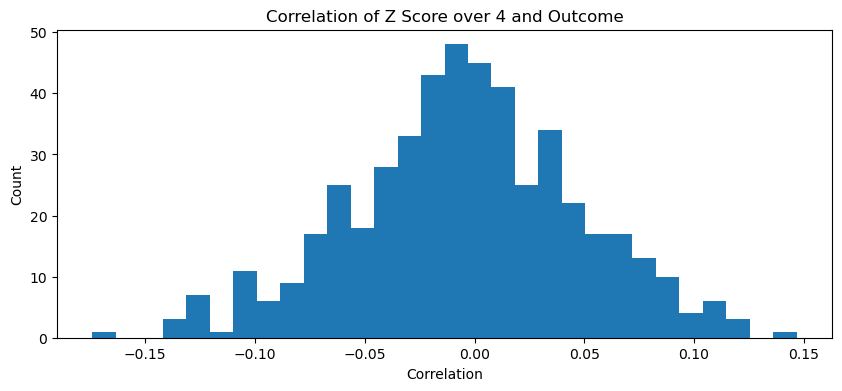

In [76]:
fig, ax = plt.subplots(figsize=(10,4))
correlation=[]
for col in z_score_over_4.columns:
    corr = z_score_over_4[col].corr(z_score_over_4['death_from_cancer'])
    correlation.append(corr)

  
correlation.pop(0)
ax.hist(correlation,  bins=30)
ax.set_xlabel("Correlation")
ax.set_ylabel("Count")
ax.set_title('Correlation of Z Score over 4 and Outcome')

plt.show()


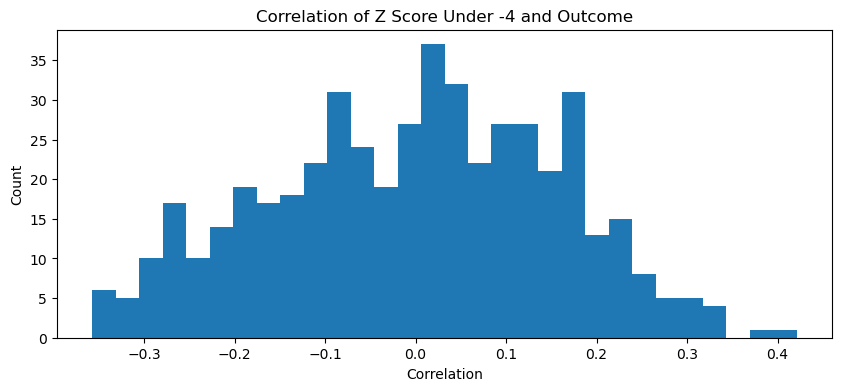

In [77]:
fig, ax = plt.subplots(figsize=(10,4))
correlation=[]
for col in z_score_under_neg_4.columns:
    corr = z_score_under_neg_4[col].corr(z_score_under_neg_4['death_from_cancer'])
    correlation.append(corr)
    
  
correlation.pop(0)
ax.hist(correlation,  bins=30)
ax.set_xlabel("Correlation")
ax.set_ylabel("Count")
ax.set_title('Correlation of Z Score Under -4 and Outcome')

plt.show()


Now we are getting somewhere! The positive z scores don't show any correlation, but there is more correlation with the patients with z_scores under -4. 

Next I want to find what columns contain these low values, and find the p value. 

In [78]:
# Filter the DataFrame to keep only the rows where the values are <= -4

#rename df to be easier to type:
low_z = z_score_under_neg_4

#looking to see which genes have low z scores (under -4)
low_z_bool = z_scores_id[(z_scores_id.iloc[:, 2:] < -4)].any().sort_values(ascending=False)
low_z_bool.head()

C:\Users\leann\AppData\Local\Temp\ipykernel_38812\1357939778.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'bool_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  low_z_bool = z_scores_id[(z_scores_id.iloc[:, 2:] < -4)].any().sort_values(ascending=False)


spen       True
stat3      True
ppp2r2a    True
inhba      True
ncstn      True
dtype: bool

In [79]:
#filtering my dataframe to make it so all values over -4 are NAN

# Create a boolean mask of values less than or equal to -4
mask = low_z.iloc[:, 2:] <= -4

# Use the where method to replace values greater than -4 with NaN
low_z_filtered = low_z.iloc[:, 2:].where(mask, other=np.nan)

# Combine the patient_id and death_from_cancer columns with the filtered z-score data
low_z_filtered = pd.concat([low_z.iloc[:, :1], low_z_filtered], axis=1)
low_z_filtered.head()


death_from_cancer  palb2  pten  tp53  atm  cdh1  chek2  nbn  nf1  \
patient_id                                                                    
39                         1    NaN   NaN   NaN  NaN   NaN    NaN  NaN  NaN   
48                         1    NaN   NaN   NaN  NaN   NaN    NaN  NaN  NaN   
53                         1    NaN   NaN   NaN  NaN   NaN    NaN  NaN  NaN   
54                         1    NaN   NaN   NaN  NaN   NaN    NaN  NaN  NaN   
56                         1    NaN   NaN   NaN  NaN   NaN    NaN  NaN  NaN   

            stk11  bard1  mlh1  msh2  msh6  pms2  epcam  rad51c  rad51d  \
patient_id                                                                
39            NaN    NaN   NaN   NaN   NaN   NaN    NaN     NaN     NaN   
48            NaN    NaN   NaN   NaN   NaN   NaN    NaN     NaN     NaN   
53            NaN    NaN   NaN   NaN   NaN   NaN    NaN     NaN     NaN   
54            NaN    NaN   NaN   NaN   NaN   NaN    NaN     NaN     NaN   
56            NaN    NaN   NaN   NaN   NaN   NaN    NaN     NaN     NaN   

            rad50  rb1  rbl1  rbl2  ccna1  ccnb1  cdk1  ccne1  cdk2  cdc25a  \
patient_id                                                                    
39            NaN  NaN   NaN   NaN    NaN    NaN   NaN    NaN   NaN     NaN   
48            NaN  NaN   NaN   NaN    NaN    NaN   NaN    NaN   NaN     NaN   
53            NaN  NaN   NaN   NaN    NaN    NaN   NaN    NaN   NaN     NaN   
54            NaN  NaN   NaN   NaN    NaN    NaN   NaN    NaN   NaN     NaN   
56            NaN  NaN   NaN   NaN    NaN    NaN   NaN    NaN   NaN     NaN   

            ccnd1  cdk4  cdk6  ccnd2  cdkn2a  cdkn2b  myc  cdkn1a  cdkn1b  \
patient_id                                                                  
39            NaN   NaN   NaN    NaN     NaN     NaN  NaN     NaN     NaN   
48            NaN   NaN   NaN    NaN     NaN     NaN  NaN     NaN     NaN   
53            NaN   NaN   NaN    NaN     NaN     NaN  NaN     NaN     NaN   
54            NaN   NaN   NaN    NaN     NaN     NaN  NaN     NaN     NaN   
56            NaN   NaN   NaN    NaN     NaN     NaN  NaN     NaN     NaN   

            e2f1  e2f2  e2f3  e2f4  e2f5  e2f6  e2f7  e2f8  src  jak1  jak2  \
patient_id                                                                    
39           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
48           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
53           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
54           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   
56           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN   

            stat1  stat2  stat3  stat5a  stat5b  mdm2  tp53bp1  adam10  \
patient_id                                                               
39            NaN    NaN    NaN     NaN     NaN   NaN      NaN     NaN   
48            NaN    NaN    NaN     NaN     NaN   NaN      NaN     NaN   
53            NaN    NaN    NaN     NaN     NaN   NaN      NaN     NaN   
54            NaN    NaN    NaN     NaN     NaN   NaN      NaN     NaN   
56            NaN    NaN    NaN     NaN     NaN   NaN      NaN     NaN   

            adam17  aph1a  aph1b  arrdc1  cir1  ctbp1  ctbp2  cul1  dll1  \
patient_id                                                                 
39             NaN    NaN    NaN     NaN   NaN    NaN    NaN   NaN   NaN   
48             NaN    NaN    NaN     NaN   NaN    NaN    NaN   NaN   NaN   
53             NaN    NaN    NaN     NaN   NaN    NaN    NaN   NaN   NaN   
54             NaN    NaN    NaN     NaN   NaN    NaN    NaN   NaN   NaN   
56             NaN    NaN    NaN     NaN   NaN    NaN    NaN   NaN   NaN   

            dll3  dll4  dtx1  dtx2  dtx3  dtx4  ep300  fbxw7  hdac1  hdac2  \
patient_id                                                                   
39           NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN    NaN    NaN 

In [80]:
low_z_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 39 to 7195
Columns: 488 entries, death_from_cancer to ugt2b7
dtypes: category(1), float64(487)
memory usage: 396.7 KB


In [81]:
from scipy.stats import mannwhitneyu
# null hypothsis is that z score makes no difference on outcome.Do a Mann Whitney U Test.
# this test is used when data are not normally distributed. Tests if sample mans ar equal or not, often used in medical trials. 

# define the two groups based on the death_from_cancer column
survived_other_causes= low_z[low_z['death_from_cancer'] == 1]
death_disease = low_z[low_z['death_from_cancer'] == 0]

# loop over each column and perform the Mann-Whitney U-test
p_values = []
for col in low_z.columns[2:]:
    stat, p = mannwhitneyu(survived_other_causes[col].dropna(), death_disease[col].dropna())
    p_values.append(p)

# create a new dataframe with the p-values for each column
p_values_df = pd.DataFrame({'gene': low_z.columns[2:], 'p_value': p_values})
p_values_df.head()

gene   p_value
0  palb2  0.572984
1   pten  0.078664
2   tp53  0.367490
3    atm  0.258182
4   cdh1  0.873956

In [82]:
p_significant = p_values_df[p_values_df['p_value']<= 0.05]
p_significant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 8 to 482
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gene     127 non-null    object 
 1   p_value  127 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [83]:
p_significant.sort_values(by='p_value').head()

gene   p_value
436   cyb5a  0.000017
79     jag2  0.000069
225   nfkb2  0.000089
399  setdb1  0.000237
367   muc16  0.000278

In [84]:
p_significant.sort_values(by='p_value').head(25)

gene   p_value
436     cyb5a  0.000017
79       jag2  0.000069
225     nfkb2  0.000089
399    setdb1  0.000237
367     muc16  0.000278
387     prkcz  0.000308
469       ran  0.000342
18        rb1  0.000562
397    setd1a  0.000576
455   hsd17b4  0.000598
266    tgfbr2  0.000694
249     rptor  0.000844
199     mapk9  0.000952
173      inha  0.000952
449  hsd17b11  0.000975
176     itgav  0.001153
37       e2f2  0.001564
371      nek1  0.001796
167     gsk3b  0.001923
85      ncor2  0.001923
24      ccne1  0.001923
480       st7  0.002106
431      akt3  0.002279
250   slc19a1  0.002331
197     mapk7  0.002817

In [120]:
# CHECKING TO SEE IF THE TOP 10 SHAP SCORES ALSO HAVE SIGNIFICANT P VALUES

genes_to_check = ['aurka', 'e3f3', 'stata5a', 'bcl2', 'mapt', 'lama2', 'cyb5a', 'aph1b', 'hsd17b8', 'gata3']

genes_present = p_significant[p_significant['gene'].isin(genes_to_check)]

for index, row in genes_present.iterrows():
    gene_name = row['gene']
    p_value = row['p_value']
    print(f"Gene: {gene_name}, p-value: {p_value}")



Gene: aph1b, p-value: 0.00606840801472325
Gene: aurka, p-value: 0.012148912439336223
Gene: lama2, p-value: 0.02352659612604546
Gene: cyb5a, p-value: 1.7339371774430012e-05


Now I have the above genes where my null hypothesis is false, so these genes may impact outcome if the z score is under -4. I don't know what to do about this now. I have 127 genes of interest out of the original 487. 

In [86]:
#list of columns with p score > 0.05
sig_genes = p_significant['gene'].tolist()
print(sig_genes)

['stk11', 'bard1', 'mlh1', 'rad51c', 'rb1', 'rbl2', 'ccne1', 'ccnd2', 'e2f2', 'e2f3', 'e2f7', 'src', 'jak1', 'jak2', 'stat1', 'stat2', 'stat3', 'tp53bp1', 'adam10', 'aph1b', 'cir1', 'ctbp1', 'cul1', 'dll3', 'dtx2', 'hdac1', 'hes1', 'jag2', 'kdm5a', 'ncor2', 'ncstn', 'notch1', 'psen1', 'hey1', 'akt1', 'akt1s1', 'aurka', 'bad', 'bmp3', 'bmpr2', 'braf', 'casp6', 'casp8', 'cxcr1', 'eif4e', 'foxo3', 'gsk3b', 'hras', 'inha', 'itgav', 'map2k1', 'map2k2', 'map2k4', 'map2k5', 'mapk6', 'mapk7', 'mapk9', 'mmp10', 'mmp15', 'mmp28', 'nfkb2', 'pdpk1', 'rab25', 'raf1', 'rps6kb2', 'rptor', 'slc19a1', 'smad4', 'tgfbr2', 'kmt2c', 'ncor1', 'runx1', 'abcb1', 'abcc10', 'fgf2', 'map4', 'tubb4b', 'afdn', 'arid5b', 'asxl1', 'col22a1', 'dtwd2', 'fancd2', 'hdac9', 'kdm6a', 'lama2', 'ldlrap1', 'lifr', 'lipi', 'muc16', 'nek1', 'nr3c1', 'nt5e', 'palld', 'ppp2r2a', 'prkcz', 'prkg1', 'sbno1', 'setd1a', 'setdb1', 'sf3b1', 'sgcd', 'smarcb1', 'smarcd1', 'thsd7a', 'ttyh1', 'utrn', 'akr1c2', 'akr1c3', 'akr1c4', 'akt3', '

In [87]:
# looking at the correlation coefficant and p value for the gene with the most significant p value:
corr, p = pearsonr(z_score_under_neg_4['cyb5a'], z_score_under_neg_4['death_from_cancer'])

# Print the correlation coefficient and its associated p-value
print('Correlation coefficient:', corr)
print('P-value:', p)


Correlation coefficient: 0.4211692828223544
P-value: 8.50320439790907e-06


Now I want to create a new dataframe with just these genes, and see what I see there. 

In [88]:
# First make a new dataframe with the patient id and outcome:

z_scores_sig = cancer_data[['patient_id','death_from_cancer']]

# Now add in the gene columns if they are in sig_genes

# select the columns I want from 'cancer_data'
cancer_data_subset = cancer_data.loc[:, sig_genes]

# merge the subset dataframe with 'z_scores_sig' based on their indices
z_scores_sig = z_scores_sig.merge(cancer_data_subset, left_index=True, right_index=True)

z_scores_sig.head()

patient_id death_from_cancer   stk11   bard1    mlh1  rad51c     rb1  \
0           0                 1 -0.4294 -1.1201 -0.4844 -0.6508 -0.2770   
1           2                 1  0.5120  0.4390  1.2266 -0.4018 -1.7488   
2           5                 0  0.2362 -0.1721 -1.7910 -0.0391  1.4142   
3           6                 1  1.0078 -0.4010 -1.3905 -0.3098  1.5345   
4           8                 0 -0.2961  0.6320 -0.3582 -0.2652  1.0158   

     rbl2   ccne1   ccnd2    e2f2    e2f3    e2f7     src    jak1    jak2  \
0  0.0615 -1.3388  1.4313 -1.8799 -1.3629 -1.3917 -1.0737  1.1097  1.6186   
1  0.7835 -0.6273  0.0546 -0.3327 -1.4560 -0.4915 -0.3297  0.9804 -0.0104   
2 -0.0662 -0.1245  0.8958 -1.4859 -0.4127 -0.3549 -0.7181  1.5835  0.7379   
3  0.7279 -0.6651  1.1455 -1.5404 -0.2119  1.3434 -0.3804  0.6194  0.8552   
4  0.6618 -1.0514 -1.0195  0.4509 -0.4449 -0.0650  0.9720  0.0461  0.1645   

    stat1   stat2   stat3  tp53bp1  adam10   aph1b    cir1   ctbp1    cul1  \
0  0.0413 -0.7556  0.9765  -0.6271 -0.5319 -0.0098 -0.2752 -1.1021  0.4469   
1 -1.1940 -0.7991 -0.8428  -1.5924 -1.2672  0.6880  1.5911  1.1926 -0.4113   
2 -0.8346 -1.3487 -0.2243   0.7590  2.0364 -0.4959  1.6744 -2.2695  0.1616   
3  0.3317 -0.5512 -1.2401  -1.0064  1.4659 -1.2458  2.6438 -0.7268  0.1933   
4  0.2677  0.3308 -0.5049   0.1063  0.9378  0.3690  0.2017 -0.8767 -0.6839   

     dll3    dtx2   hdac1    hes1    jag2   kdm5a   ncor2   ncstn  notch1  \
0 -0.5067 -1.8994 -1.6822  0.8322  0.2445 -0.9667  0.4684 -2.0007 -0.3395   
1 -0.1581 -0.1775  1.6267  0.2582 -0.6473  0.7122 -0.0066 -0.9120 -1.4125   
2  0.9493  0.2312 -1.8103  1.1837 -1.2545 -1.6218 -1.9701 -1.4975 -1.0102   
3  1.6109 -0.2765 -0.3412 -0.1616 -0.8333 -2.2726 -0.9941 -2.5452 -1.5746   
4 -0.8212 -0.7525  0.4816 -1.2850 -1.0050 -0.0353 -2.1310 -0.7509 -0.0075   

    psen1    hey1    akt1  akt1s1   aurka     bad    bmp3   bmpr2    braf  \
0  0.4056 -0.2490 -1.1280 -0.4574 -1.5733 -0.3367  1.8812  0.9883 -0.6387   
1  0.6743  0.3879  0.0312 -0.1056 -0.3052  1.8906 -0.3217  0.1759  0.5886   
2  1.3108  1.4153  0.9269  0.1185 -0.2248  1.3090  0.2980  1.7894  0.7275   
3  1.1638 -0.2092  1.2375 -1.0408  2.0447 -0.1371  0.9754  2.3596  0.2123   
4  2.1816 -0.4913 -0.9541 -0.8911  0.5882  0.5063  0.6704 -0.7718 -0.2628   

    casp6   casp8   cxcr1   eif4e   foxo3   gsk3b    hras    inha   itgav  \
0 -0.8434  0.1816  0.9278 -0.2314  0.9213 -0.7982 -0.9923  0.0883 -0.4337   
1  1.7652  1.8819 -1.2491  0.9246 -1.6144 -0.0094  0.9679 -0.2797 -0.7036   
2  1.7003  0.6432  0.0089  3.1838 -1.2823 -1.7768 -0.6058 -0.4539  2.2121   
3  0.0513 -1.1012 -0.0706  2.9343 -1.2511 -1.6895  0.9831  1.9837  1.3652   
4 -0.5943  1.8931 -0.9502  0.4861 -1.5713 -0.3001  0.2881 -0.1702 -1.2198   

   map2k1  map2k2  map2k4  map2k5   mapk6   mapk7   mapk9   mmp10   mmp15  \
0  0.4229 -0.0078 -0.0279 -0.2537 -0.4627  0.3205 -0.8403 -0.7603 -0.8050   
1 -2.0640 -0.5408 -1.1421 -1.0739 -0.9976 -0.6786  0.5150 -0.7450 -0.0552   
2  0.0169 -0.8582  0.6299 -2.8788  1.8587 -1.6654  1.0738 -0.2289  0.0417   
3 -0.2496 -1.4272  1.0026 -2.2113  0.2379 -1.2308  0.2743 -0.3216  1.7173   
4  0.4079 -2.2363 -0.3795 -0.4151  0.9238 -1.9312 -0.1982 -0.6322 -0.2091   

    mmp28   nfkb2   pdpk1   rab25    raf1  rps6kb2   rptor  slc19a1   smad4  \
0  3.9945 -0.3837 -0.2005 -1.6133 -0.4185  -1.8694  0.0165  -0.0677  0.2348   
1  0.2456 -0.8394  0.2841  0.4303 -0.1043   2.3000 -1.3098  -1.1252  0.8578   
2  0.3810 -0.8461 -0.4960  0.3867 -1.8437  -1.0724 -1.5115  -0.7975  1.4349   
3  0.8236 -0.7812 -0.7175  0.2140 -0.6233  -1.5166  0.4326  -0.4880  0.8580   
4 -0.3306 -0.3511  1.4198 -0.6780 -1.2441   1.4917 -0.3344   2.3240  0.1512   

   tgfbr2   kmt2c   ncor1   runx1   abcb1  abcc10    fgf2    map4  tubb4b  \
0  2.2907 -0.9045  0.3529 -1.9710  1.6758 -0.1948  2.4435 -0.3917 -0.4113   
1 -0.6814 -0.0208  0.1916  0.6746 -1.1793 -0.9788 -1.1548  0.9038  0.7791   
2  0.2776 -0.5063 -1.7078 -1.0401 -0.4457 -1.5536  0.5059 -0.6

In [89]:
z_scores_sig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Columns: 129 entries, patient_id to tnk2
dtypes: category(1), float64(127), int64(1)
memory usage: 1.9 MB


CONCLUSION:There are 129 genes have are weakly correlated to survival. I'm leaving everything as-is for now. 

## 2.7 Genetic Mutation Data <a id='2.6.7_genetic'></a>

How many columns of genetic mutations are in the dataset?

In [90]:
#getting a list of gene mutation columns
gene_mut_columns = [col for col in cancer_data.columns if '_mut' in col]
number_gen_mut_columns = len(gene_mut_columns)
print('number of gene mutation columns: ',number_gen_mut_columns)

number of gene mutation columns:  173


I have seen previously that some of the columns have two gene mutation entries for one patient. How often does this show up?

I have seen previously that some of the columns have two gene mutation entries for one patient. How often does this show up?

In [91]:
#first make a dataframe that's a subset of cancer_data, containing only the genetic mutation data. 
gene_mut = cancer_data.loc[:,'pik3ca_mut':]
gene_mut.head()


pik3ca_mut tp53_mut muc16_mut ahnak2_mut kmt2c_mut syne1_mut gata3_mut  \
0          0        0         0          0         0         0         0   
1          0    H178P         0          0         0         0         0   
2     H1047R        0         0          0         0         0         0   
3      E542K        0         0          0         0         0         0   
4          0    S241F         0          0         0         0         0   

  map3k1_mut ahnak_mut dnah11_mut cdh1_mut dnah2_mut kmt2d_mut ush2a_mut  \
0          0         0          0        0         0         0         0   
1          0         0          0        0         0         0         0   
2          0         0          0        0         0         0         0   
3          0         0          0        0         0         0         0   
4          0         0          0        0         0         0         0   

  ryr2_mut dnah5_mut herc2_mut pde4dip_mut akap9_mut  tg_mut birc6_mut  \
0        0         0         0           0         0       0         0   
1        0         0         0           0         0       0         0   
2        0         0         0           0         0       0         0   
3        0         0         0           0         0       0         0   
4        0         0         0           0         0  F2321Y         0   

  utrn_mut tbx3_mut col6a3_mut arid1a_mut lama2_mut notch1_mut cbfb_mut  \
0        0        0          0          0         0          0        0   
1        0        0          0          0         0          0        0   
2        0        0          0          0         0          0        0   
3        0        0          0          0         0          0        0   
4        0        0          0          0         0          0        0   

  ncor2_mut col12a1_mut col22a1_mut pten_mut akt1_mut atr_mut thada_mut  \
0         0           0           0        0        0       0         0   
1         0           0           0        0        0       0         0   
2         0           0           0        0        0       0         0   
3         0           0           0        0        0       0         0   
4         0           0           0        0        0       0         0   

  ncor1_mut stab2_mut myh9_mut runx1_mut nf1_mut map2k4_mut ros1_mut  \
0         0         0        0         0       0          0        0   
1         0         0        0         0       0          0        0   
2    L1463P         0        0         0       0          0        0   
3         0         0        0         0       0          0        0   
4         0         0        0         0       0          0        0   

  lamb3_mut arid1b_mut erbb2_mut sf3b1_mut shank2_mut ep300_mut ptprd_mut  \
0         0          0         0         0          0         0         0   
1         0          0         0         0          0         0         0   
2         0          0         0         0          0         0         0   
3         0          0         0         0          0         0         0   
4         0          0         0         0          0         0         0   

  usp9x_mut setd2_mut setd1a_mut thsd7a_mut afdn_mut erbb3_mut rb1_mut  \
0         0         0          0          0        0         0       0   
1         0         0          0          0        0         0       0   
2         0         0          0          0        0         0       0   
3         0         0          0          0        0         0       0   
4         0         0          0          0        0         0       0   

  myo1a_mut alk_mut fanca_mut adgra2_mut ubr5_mut pik3r1_mut myo3a_mut  \
0         0       0         0          0        0          0         0   
1         0       0         0          0        0          0         0   
2         0       0         0          0        0          0         0   
3         0       0         0          0        0          0         0   
4         0       0         0 

I know that in the data, multiple mutations for a single patient and gene are entered by including a space between each mutation. I will search for spaces, but first need to strip spaces from the beginning and end of each entry.

In [92]:
#convert into object
gene_mut = gene_mut.astype('object')

#strip the spaces from either side of entries in dataframe

gene_mut_stripped = gene_mut.apply(lambda x: x.str.strip())


Now I will get the count of the genetic mutations that have more than one mutation listed at a time:

In [93]:

mutation_counts = gene_mut.apply(lambda x: x.str.count(' ').sum())
non_zero_counts = mutation_counts[mutation_counts > 0]
total_non_zero_counts = non_zero_counts.sum()
print('TOTAL number of occurances of more than one mutation per gene per patient: ',total_non_zero_counts)

#and also want to know the total number of mutations listed overall:
#finding the entries that are non zero
non_zero_mutation = gene_mut.ne('0')
#summing the boolean values and then converting to scalar with second sum. 
#This does not include the 'extras' where there are more than one mutation listed at a time 
total_mut_count = non_zero_mutation.sum().sum()
print('total mutation count: ',total_mut_count)

print('\ntally of mutiple mutations listed per patient, per gene:\n',non_zero_counts.to_string())

TOTAL number of occurances of more than one mutation per gene per patient:  851
total mutation count:  9728

tally of mutiple mutations listed per patient, per gene:
 pik3ca_mut     123
tp53_mut        21
muc16_mut       74
ahnak2_mut     116
kmt2c_mut       33
syne1_mut       37
gata3_mut        8
map3k1_mut      82
ahnak_mut       21
dnah11_mut      10
cdh1_mut         6
dnah2_mut       13
kmt2d_mut        9
ush2a_mut        3
ryr2_mut         9
dnah5_mut       15
herc2_mut       11
pde4dip_mut      8
akap9_mut        8
tg_mut           5
birc6_mut        4
utrn_mut         5
tbx3_mut        19
col6a3_mut       4
arid1a_mut      14
lama2_mut        3
notch1_mut       7
cbfb_mut         3
ncor2_mut        5
col12a1_mut      2
col22a1_mut      4
pten_mut         8
atr_mut          2
thada_mut        4
ncor1_mut        5
stab2_mut        7
myh9_mut         3
runx1_mut        7
nf1_mut          6
map2k4_mut       1
ros1_mut         6
lamb3_mut        1
erbb2_mut        5
sf3b1_mut       

I now want to know if any patients have more than 2 gene mutations listed at a time. 

In [94]:
#define a funtion to search for more than 2 mutation in a cell:

def count_mut(s):
    return s.count(' ') + 1

#apply the function:

muts_3plus = gene_mut_stripped.apply(lambda x: x.apply(count_mut))

# find the columns that contain at least one cell with 3 mutations
columns_muts_3 = muts_3plus.columns[muts_3plus.apply(lambda x: (x == 3).any())]

print('columns with 3 mutations per patient:\n ',columns_muts_3)

#see if any columns contain 4 or more mutations

columns_muts_4 = muts_3plus.columns[muts_3plus.apply(lambda x: (x == 4).any())]

print('\ncolumns with 4 mutations per patient: \n ',columns_muts_4)


columns_muts_5 = muts_3plus.columns[muts_3plus.apply(lambda x: (x >= 5).any())]

print('\ncolumns with 5 mutations per patient: \n ',columns_muts_5)


columns with 3 mutations per patient:
  Index(['pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut',
       'syne1_mut', 'map3k1_mut', 'ahnak_mut', 'kmt2d_mut', 'ryr2_mut',
       'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'tbx3_mut', 'arid1a_mut',
       'pten_mut', 'thada_mut', 'stab2_mut', 'erbb2_mut', 'apc_mut',
       'kdm6a_mut', 'ctnna3_mut', 'usp28_mut', 'arid5b_mut'],
      dtype='object')

columns with 4 mutations per patient: 
  Index(['pik3ca_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'map3k1_mut'], dtype='object')

columns with 5 mutations per patient: 
  Index(['tp53_mut', 'muc16_mut', 'ahnak2_mut', 'syne1_mut', 'arid1a_mut',
       'shank2_mut', 'brip1_mut'],
      dtype='object')


There's no easy end in sight here, so I'm going to do a count to find the maximum number of mutations. 

In [95]:
# Define a function to count the number of mutations in a cell
def count_mutations(cell):
    #check if cell contents is a string
    if isinstance(cell, str):
    #if so, splits it into a list and counts how many mutations are in the list
        return len(cell.split())
    else:
        return 0

# Apply the function to each cell in the dataframe
mutation_counts_cell = gene_mut_stripped.applymap(count_mutations)

# Find the maximum number of mutations
max_mutations = mutation_counts_cell.max().max()

print(f"The maximum number of mutations in a single cell is {max_mutations}.")


The maximum number of mutations in a single cell is 10.


<b>Summary so far:</b> We have 173 columns of genetic mutation data, with 9728 total cells containing mutations, and 851 of these contain more than 1 mutation. The maximum number of mutations in a single cell is 10, but the majority with multiple mutations per cell only have 2. 

Next steps: I need to figure out how to split the data, and then I can do more EDA once that happens. 

In [96]:
#First I want to add the patient_id column back to the mutation data in case I need this. 
patient_id = cancer_data['patient_id']
gene_mut_merged = pd.concat([patient_id, gene_mut_stripped], axis=1)
gene_mut_merged.set_index('patient_id')

pik3ca_mut tp53_mut muc16_mut ahnak2_mut kmt2c_mut syne1_mut  \
patient_id                                                                
0                   0        0         0          0         0         0   
2                   0    H178P         0          0         0         0   
5              H1047R        0         0          0         0         0   
6               E542K        0         0          0         0         0   
8                   0    S241F         0          0         0         0   
...               ...      ...       ...        ...       ...       ...   
7295            E542K        0         0          0         0         0   
7296                0    M237I         0          0         0         0   
7297                0        0         0          0         0         0   
7298                0        0         0     V3102M         0         0   
7299                0        0         0          0         0         0   

                         gata3_mut map3k1_mut ahnak_mut dnah11_mut cdh1_mut  \
patient_id                                                                    
0                                0          0         0          0        0   
2                                0          0         0          0        0   
5                                0          0         0          0        0   
6                                0          0         0          0        0   
8                                0          0         0          0        0   
...                            ...        ...       ...        ...      ...   
7295                             0     R1482*         0          0        0   
7296                             0          0         0          0        0   
7297                             0          0         0          0        0   
7298        S404Kfs*104 L94Pfs*117          0    R5779C      P232L        0   
7299                             0          0         0          0        0   

           dnah2_mut kmt2d_mut ush2a_mut       ryr2_mut dnah5_mut herc2_mut  \
patient_id                                                                    
0                  0         0         0              0         0         0   
2                  0         0         0              0         0         0   
5                  0         0         0              0         0         0   
6                  0         0         0              0         0         0   
8                  0         0         0              0         0         0   
...              ...       ...       ...            ...       ...       ...   
7295               0         0         0              0         0         0   
7296               0    P2931A         0  S3592F P3579S         0         0   
7297               0         0         0              0         0         0   
7298               0         0         0              0         0         0   
7299               0         0     P321L              0         0         0   

               pde4dip_mut akap9_mut  tg_mut birc6_mut utrn_mut tbx3_mut  \
patient_id                                                                 
0                        0         0       0         0        0        0   
2                        0         0       0         0        0        0   
5                        0         0       0         0        0        0   
6                        0         0       0         0        0        0   
8                        0         0  F2321Y         0        0        0   
...                    ...       ...     ...       ...      ...      ...   
7295                     0         0       0         0        0        0   
7296        K1507_T1509del         0       0         0        0        0   
7297                     0         0       0         0        0        0   
7298                     0         0       0         0        0        0   
7299                     0         0       0         0        0    

### 2.7.1 Convert gene mutation columns into binary  <a id='2.7.1_binary'></a>
Our dataset is getting large and complicated, and I think that the first thing we want to do is to convert each cell into a 0 or 1 to indicate if there are mutation(s) present or not.
    

In [97]:
mutations = gene_mut_merged.copy()

for i in range(len(mutations)):
    for j in range(1, len(mutations.columns)):
        if len(str(mutations.iloc[i,j])) > 1:
            mutations.iloc[i,j] = 1
        else:
            mutations.iloc[i,j] = 0

    

In [98]:
mutations.head()

patient_id pik3ca_mut tp53_mut muc16_mut ahnak2_mut kmt2c_mut syne1_mut  \
0           0          0        0         0          0         0         0   
1           2          0        1         0          0         0         0   
2           5          1        0         0          0         0         0   
3           6          1        0         0          0         0         0   
4           8          0        1         0          0         0         0   

  gata3_mut map3k1_mut ahnak_mut dnah11_mut cdh1_mut dnah2_mut kmt2d_mut  \
0         0          0         0          0        0         0         0   
1         0          0         0          0        0         0         0   
2         0          0         0          0        0         0         0   
3         0          0         0          0        0         0         0   
4         0          0         0          0        0         0         0   

  ush2a_mut ryr2_mut dnah5_mut herc2_mut pde4dip_mut akap9_mut tg_mut  \
0         0        0         0         0           0         0      0   
1         0        0         0         0           0         0      0   
2         0        0         0         0           0         0      0   
3         0        0         0         0           0         0      0   
4         0        0         0         0           0         0      1   

  birc6_mut utrn_mut tbx3_mut col6a3_mut arid1a_mut lama2_mut notch1_mut  \
0         0        0        0          0          0         0          0   
1         0        0        0          0          0         0          0   
2         0        0        0          0          0         0          0   
3         0        0        0          0          0         0          0   
4         0        0        0          0          0         0          0   

  cbfb_mut ncor2_mut col12a1_mut col22a1_mut pten_mut akt1_mut atr_mut  \
0        0         0           0           0        0        0       0   
1        0         0           0           0        0        0       0   
2        0         0           0           0        0        0       0   
3        0         0           0           0        0        0       0   
4        0         0           0           0        0        0       0   

  thada_mut ncor1_mut stab2_mut myh9_mut runx1_mut nf1_mut map2k4_mut  \
0         0         0         0        0         0       0          0   
1         0         0         0        0         0       0          0   
2         0         1         0        0         0       0          0   
3         0         0         0        0         0       0          0   
4         0         0         0        0         0       0          0   

  ros1_mut lamb3_mut arid1b_mut erbb2_mut sf3b1_mut shank2_mut ep300_mut  \
0        0         0          0         0         0          0         0   
1        0         0          0         0         0          0         0   
2        0         0          0         0         0          0         0   
3        0         0          0         0         0          0         0   
4        0         0          0         0         0          0         0   

  ptprd_mut usp9x_mut setd2_mut setd1a_mut thsd7a_mut afdn_mut erbb3_mut  \
0         0         0         0          0          0        0         0   
1         0         0         0          0          0        0         0   
2         0         0         0          0          0        0         0   
3         0         0         0          0          0        0         0   
4         0         0         0          0          0        0         0   

  rb1_mut myo1a_mut alk_mut fanca_mut adgra2_mut ubr5_mut pik3r1_mut  \
0       0         0       0         0          0        0          0   
1       0         0       0         0          0        0          0   
2       0         0       0         0          0        0          0   
3       0         0       0         0          0        0          0   
4       0         0    

In [99]:
#I want to look at just the mutations without the patient_id.

mutations_no_id = mutations.iloc[:,1:]

mutations_no_id.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Columns: 173 entries, pik3ca_mut to siah1_mut
dtypes: object(173)
memory usage: 2.5+ MB


I see that the dtype is still object, so I should change it to int.

In [100]:
mutations = mutations.astype('int')
mutations_no_id = mutations_no_id.astype('int')
mutations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Columns: 174 entries, patient_id to siah1_mut
dtypes: int32(174)
memory usage: 1.3 MB


In [101]:
mutations_no_id.describe()

pik3ca_mut     tp53_mut    muc16_mut   ahnak2_mut    kmt2c_mut  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.417236     0.345770     0.171308     0.163426     0.122964   
std       0.493232     0.475744     0.376877     0.369851     0.328482   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         syne1_mut    gata3_mut   map3k1_mut    ahnak_mut   dnah11_mut  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.121913     0.120862     0.104046     0.091960     0.091960   
std       0.327271     0.326052     0.305401     0.289046     0.289046   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          cdh1_mut    dnah2_mut    kmt2d_mut    ush2a_mut     ryr2_mut  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.089858     0.078823     0.073568     0.073043     0.070415   
std       0.286054     0.269533     0.261135     0.260275     0.255913   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         dnah5_mut    herc2_mut  pde4dip_mut    akap9_mut       tg_mut  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.069364     0.067262     0.062007     0.061482     0.059905   
std       0.254139     0.250541     0.241232     0.240275     0.237374   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         birc6_mut     utrn_mut     tbx3_mut   col6a3_mut   arid1a_mut  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.056227     0.053600     0.053074     0.050972     0.050447   
std       0.230420     0.225285     0.224240     0.219999     0.218922   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         lama2_mut   notch1_mut     cbfb_mut    ncor2_mut  col12a1_mut  \
count  1903.000000  1903.000000  1903.000000  1903.000000  1903.000000   
mean      0.049921     0.049921     0.048345     0.046768     0.043090   
std       0.217839     0.217839     0.214550     0.211198     0.203113   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

      

### 2.7.2 Correlations of Mutation Data <a id='2.7.2_corr'></a>

In [102]:
# Find the most common 25 genes for mutations to take place, and count them.
mut_sum = mutations_no_id.sum()
top_25 = mut_sum.head(25)
top_25

pik3ca_mut     794
tp53_mut       658
muc16_mut      326
ahnak2_mut     311
kmt2c_mut      234
syne1_mut      232
gata3_mut      230
map3k1_mut     198
ahnak_mut      175
dnah11_mut     175
cdh1_mut       171
dnah2_mut      150
kmt2d_mut      140
ush2a_mut      139
ryr2_mut       134
dnah5_mut      132
herc2_mut      128
pde4dip_mut    118
akap9_mut      117
tg_mut         114
birc6_mut      107
utrn_mut       102
tbx3_mut       101
col6a3_mut      97
arid1a_mut      96
dtype: int64

So I see the most common mutations that our patients have. I would like to look at these on a plot. 

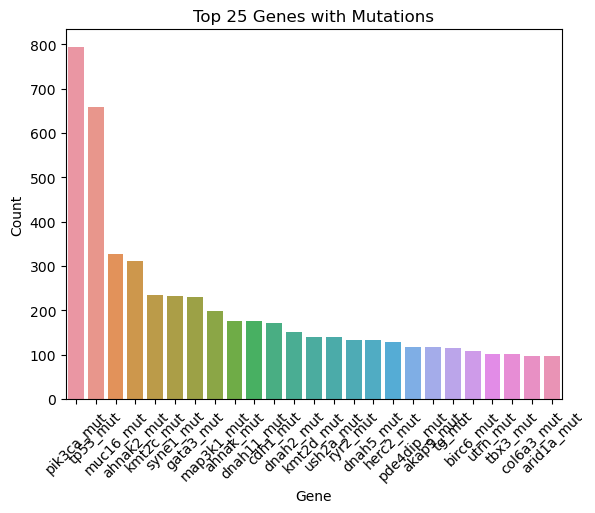

In [103]:
sns.barplot(x=top_25.index, y = top_25.values)
plt.title("Top 25 Genes with Mutations")
plt.xlabel("Gene")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show;

In [104]:
#insert the overall_survival column into 'mutation' df - 

mutations.insert(1, "overall_survival", cancer_data["overall_survival"])
mutations.head()

patient_id  overall_survival  pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  \
0           0                 1           0         0          0           0   
1           2                 1           0         1          0           0   
2           5                 0           1         0          0           0   
3           6                 1           1         0          0           0   
4           8                 0           0         1          0           0   

   kmt2c_mut  syne1_mut  gata3_mut  map3k1_mut  ahnak_mut  dnah11_mut  \
0          0          0          0           0          0           0   
1          0          0          0           0          0           0   
2          0          0          0           0          0           0   
3          0          0          0           0          0           0   
4          0          0          0           0          0           0   

   cdh1_mut  dnah2_mut  kmt2d_mut  ush2a_mut  ryr2_mut  dnah5_mut  herc2_mut  \
0         0          0          0          0         0          0          0   
1         0          0          0          0         0          0          0   
2         0          0          0          0         0          0          0   
3         0          0          0          0         0          0          0   
4         0          0          0          0         0          0          0   

   pde4dip_mut  akap9_mut  tg_mut  birc6_mut  utrn_mut  tbx3_mut  col6a3_mut  \
0            0          0       0          0         0         0           0   
1            0          0       0          0         0         0           0   
2            0          0       0          0         0         0           0   
3            0          0       0          0         0         0           0   
4            0          0       1          0         0         0           0   

   arid1a_mut  lama2_mut  notch1_mut  cbfb_mut  ncor2_mut  col12a1_mut  \
0           0          0           0         0          0            0   
1           0          0           0         0          0            0   
2           0          0           0         0          0            0   
3           0          0           0         0          0            0   
4           0          0           0         0          0            0   

   col22a1_mut  pten_mut  akt1_mut  atr_mut  thada_mut  ncor1_mut  stab2_mut  \
0            0         0         0        0          0          0          0   
1            0         0         0        0          0          0          0   
2            0         0         0        0          0          1          0   
3            0         0         0        0          0          0          0   
4            0         0         0        0          0          0          0   

   myh9_mut  runx1_mut  nf1_mut  map2k4_mut  ros1_mut  lamb3_mut  arid1b_mut  \
0         0          0        0           0         0          0           0   
1         0          0        0           0         0          0           0   
2         0          0        0           0         0          0           0   
3         0          0        0           0         0          0           0   
4         0          0        0           0         0          0           0   

   erbb2_mut  sf3b1_mut  shank2_mut  ep300_mut  ptprd_mut  usp9x_mut  \
0          0          0           0          0          0          0   
1          0          0           0          0          0          0   
2          0          0           0          0          0          0   
3          0          0           0          0          0          0   
4          0          0           0          0          0          0   

   setd2_mut  setd1a_mut  thsd7a_mut  afdn_mut  erbb3_mut  rb1_mut  myo1a_mut  \
0          0           0           0         0          0        0          0   
1          0           0           0         0          0        0          0   
2          0           0           0  

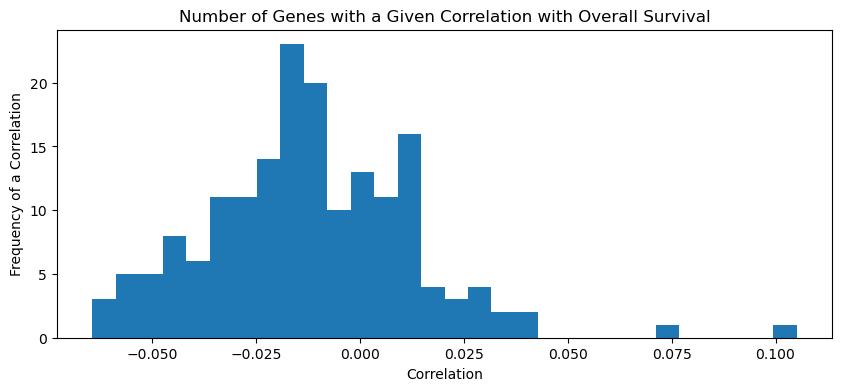

In [105]:
# plot histogram of Pearson Correlation Coefficient v number of genes with that correlation
# Doing this a similar way as I found here: https://www.kaggle.com/code/raghadalharbi/breast-cancer-survival-prediction-acc-0-779 

fig, ax = plt.subplots(figsize=(10,4))
correlation=[]
for col in mutations.drop(['patient_id'], axis = 1).columns:
    corr = mutations[[col,'overall_survival']].corr()['overall_survival'][col]
    correlation.append(corr)
    
correlation.pop(0)
ax.hist(correlation,  bins=30)
ax.set_xlabel("Correlation")
ax.set_ylabel("Frequency of a Correlation")
ax.set_title('Number of Genes with a Given Correlation with Overall Survival')


plt.show();

In the above plot, we see that there are more genes correlated with patient death than with survival, but these do not show enough correlation to further investigate down this path. 

# 2.8 Preparation for export   <a id='2.8_prep'></a>

I need to tie our data back together and confirm that everything looks good so that we can move onto the next step

The dataframes we want to look at are:
* clinical_dummies
* zscores_id
* mutations

In [106]:
# we previously saved the patient_id as a series, checking it out here. 
patient_id.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1903 entries, 0 to 1902
Series name: patient_id
Non-Null Count  Dtype
--------------  -----
1903 non-null   int64
dtypes: int64(1)
memory usage: 15.0 KB


In [107]:
# Looking at our clinical dataframe that was converted to numeric already with get_dummies method, inspecting this here.
clinical_dummies.head()

patient_id  age_at_diagnosis  lymph_nodes_examined_positive  \
0           0             75.65                             10   
1           2             43.19                              0   
2           5             48.87                              1   
3           6             47.68                              3   
4           8             76.97                              8   

   mutation_count  nottingham_prognostic_index  overall_survival_months  \
0               0                        6.044                    140.5   
1               2                        4.020                     84.6   
2               2                        4.030                    163.7   
3               1                        4.050                    164.9   
4               2                        6.080                     41.4   

   tumor_size  type_of_breast_surgery_BREAST CONSERVING  \
0        22.0                                         0   
1        10.0                                         1   
2        15.0                                         0   
3        25.0                                         0   
4        40.0                                         0   

   type_of_breast_surgery_MASTECTOMY  type_of_breast_surgery_nan  \
0                                  1                           0   
1                                  0                           0   
2                                  1                           0   
3                                  1                           0   
4                                  1                           0   

   cancer_type_Breast Cancer  cancer_type_Breast Sarcoma  \
0                          1                           0   
1                          1                           0   
2                          1                           0   
3                          1                           0   
4                          1                           0   

   cancer_type_detailed_Breast  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            0   

   cancer_type_detailed_Breast Invasive Ductal Carcinoma  \
0                                                      1   
1                                                      1   
2                                                      1   
3                                                      0   
4                                                      0   

   cancer_type_detailed_Breast Invasive Lobular Carcinoma  \
0                                                       0   
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   

   cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma  \
0                                                              0   
1                                                              0   
2                                                              0   
3                                                              0   
4                                                              0   

   cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma  \
0                                                               0   
1                                                               0   
2                                                               0   
3                                                               1   
4                                                               1   

   cancer_type_detailed_Metaplastic Breast Cancer  cancer_type_detailed_nan  \
0                                               0                         0   
1                                               0                         0   
2                                   

In [108]:
# Reset index of our clinical and mutations to 'patient_id' and make naming convention consistent

clinical_id = clinical_dummies.set_index('patient_id')
mutations_id = mutations.set_index('patient_id')
clinical_id.head()

age_at_diagnosis  lymph_nodes_examined_positive  mutation_count  \
patient_id                                                                    
0                      75.65                             10               0   
2                      43.19                              0               2   
5                      48.87                              1               2   
6                      47.68                              3               1   
8                      76.97                              8               2   

            nottingham_prognostic_index  overall_survival_months  tumor_size  \
patient_id                                                                     
0                                 6.044                    140.5        22.0   
2                                 4.020                     84.6        10.0   
5                                 4.030                    163.7        15.0   
6                                 4.050                    164.9        25.0   
8                                 6.080                     41.4        40.0   

            type_of_breast_surgery_BREAST CONSERVING  \
patient_id                                             
0                                                  0   
2                                                  1   
5                                                  0   
6                                                  0   
8                                                  0   

            type_of_breast_surgery_MASTECTOMY  type_of_breast_surgery_nan  \
patient_id                                                                  
0                                           1                           0   
2                                           0                           0   
5                                           1                           0   
6                                           1                           0   
8                                           1                           0   

            cancer_type_Breast Cancer  cancer_type_Breast Sarcoma  \
patient_id                                                          
0                                   1                           0   
2                                   1                           0   
5                                   1                           0   
6                                   1                           0   
8                                   1                           0   

            cancer_type_detailed_Breast  \
patient_id                                
0                                     0   
2                                     0   
5                                     0   
6                                     0   
8                                     0   

            cancer_type_detailed_Breast Invasive Ductal Carcinoma  \
patient_id                                                          
0                                                               1   
2                                                               1   
5                                                               1   
6                                                               0   
8                                                               0   

            cancer_type_detailed_Breast Invasive Lobular Carcinoma  \
patient_id                                                           
0                                                                0   
2                                                                0   
5                                                                0   
6                                                                0   
8                                                                0   

            cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma  \
patient_id                                                                  
0                                                

In [109]:
# Drop the death_from_cancer column from z_scores_id and mutations_id, so that when we join our 
#dataframes together we don't have repeats
z_scores_no_outcome = z_scores_id.drop('death_from_cancer',axis=1)
mutations_no_outcome = mutations_id.drop('overall_survival',axis=1)

In [110]:
z_scores_no_outcome.head()

brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn  \
patient_id                                                                   
0          -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348  0.1266 -0.8361   
2           0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419   
5          -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030   
6          -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174   
8          -0.9039 -0.7219  0.2168  0.3484  0.3897  0.9131  0.9356  0.7675   

               nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  \
patient_id                                                                   
0          -0.8578 -0.4294 -1.1201 -0.4844 -0.7483 -1.6660 -0.1250 -0.3721   
2          -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600   
5          -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553   
6          -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161   
8          -0.2940 -0.2961  0.6320 -0.3582  0.3032  0.8747  0.6323  0.3349   

            rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1  \
patient_id                                                                   
0          -0.6508 -0.1278  1.7330 -0.2770 -1.0673  0.0615  0.1034 -1.6635   
2          -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715   
5          -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967   
6          -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801   
8          -0.2652 -0.1541 -0.7631  1.0158  1.8996  0.6618 -0.7454  0.2862   

              cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  \
patient_id                                                                   
0          -2.0649 -1.3388 -0.6208 -1.7309 -0.8059 -1.1037  0.0744  1.4313   
2           0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546   
5           1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958   
6           0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248  0.3689  1.1455   
8           1.1035 -1.0514  1.5423  1.2169  0.1169  1.7648  0.8892 -1.0195   

            cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3  \
patient_id                                                                   
0          -0.5785  1.2180  2.5602  2.3152 -0.2487  0.1601 -1.8799 -1.3629   
2           0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560   
5          -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127   
6           0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610 -1.5404 -0.2119   
8           0.3664  0.7145  0.5223  1.5638  0.1562 -0.2666  0.4509 -0.4449   

              e2f4    e2f5    e2f6    e2f7    e2f8     src    jak1    jak2  \
patient_id                                                                   
0           0.1992 -0.0907 -0.1167 -1.3917 -0.8178 -1.0737  1.1097  1.6186   
2           1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297  0.9804 -0.0104   
5          -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181  1.5835  0.7379   
6          -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804  0.6194  0.8552   
8          -0.3181  2.2129  1.1063 -0.0650  1.4216  0.9720  0.0461  0.1645   

             stat1   stat2   stat3  stat5a  stat5b    mdm2  tp53bp1  adam10  \
patient_id                                                                    
0           0.0413 -0.7556  0.9765  3.9189  2.5773  0.3126  -0.6271 -0.5319   
2          -1.1940 -0.7991 -0.8428 -0.4983 -1.3251  0.8803  -1.5924 -1.2672   
5          -0.8346 -1.3487 -0.2243  0.0434 -1.0832 -0.8822   0.7590  2.0364   
6           0.3317 -0.5512 -1.2401 -0.8535 -0.0195  0.2551  -1.0064  1.4659   
8           0.2677  0.3308 -0.5049 -0.3295 -0.4278 -0.0063   0.1063  0.9378   

            adam17   aph1a   aph1b  arrdc1    cir1   ctbp1   ctbp2    cul1  \
patient_id                                                                   
0           0.8721  0

In [111]:
mutations_no_outcome.head

<bound method NDFrame.head of             pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  kmt2c_mut  syne1_mut  \
patient_id                                                                      
0                    0         0          0           0          0          0   
2                    0         1          0           0          0          0   
5                    1         0          0           0          0          0   
6                    1         0          0           0          0          0   
8                    0         1          0           0          0          0   
...                ...       ...        ...         ...        ...        ...   
7295                 1         0          0           0          0          0   
7296                 0         1          0           0          0          0   
7297                 0         0          0           0          0          0   
7298                 0         0          0           1          0          0  

Merge our datasets back together

In [112]:
num_data = pd.merge(clinical_id,z_scores_no_outcome, left_index=True, right_index=True)
num_data = pd.merge(num_data, mutations_no_outcome, left_index=True, right_index=True)
num_data.head()

age_at_diagnosis  lymph_nodes_examined_positive  mutation_count  \
patient_id                                                                    
0                      75.65                             10               0   
2                      43.19                              0               2   
5                      48.87                              1               2   
6                      47.68                              3               1   
8                      76.97                              8               2   

            nottingham_prognostic_index  overall_survival_months  tumor_size  \
patient_id                                                                     
0                                 6.044                    140.5        22.0   
2                                 4.020                     84.6        10.0   
5                                 4.030                    163.7        15.0   
6                                 4.050                    164.9        25.0   
8                                 6.080                     41.4        40.0   

            type_of_breast_surgery_BREAST CONSERVING  \
patient_id                                             
0                                                  0   
2                                                  1   
5                                                  0   
6                                                  0   
8                                                  0   

            type_of_breast_surgery_MASTECTOMY  type_of_breast_surgery_nan  \
patient_id                                                                  
0                                           1                           0   
2                                           0                           0   
5                                           1                           0   
6                                           1                           0   
8                                           1                           0   

            cancer_type_Breast Cancer  cancer_type_Breast Sarcoma  \
patient_id                                                          
0                                   1                           0   
2                                   1                           0   
5                                   1                           0   
6                                   1                           0   
8                                   1                           0   

            cancer_type_detailed_Breast  \
patient_id                                
0                                     0   
2                                     0   
5                                     0   
6                                     0   
8                                     0   

            cancer_type_detailed_Breast Invasive Ductal Carcinoma  \
patient_id                                                          
0                                                               1   
2                                                               1   
5                                                               1   
6                                                               0   
8                                                               0   

            cancer_type_detailed_Breast Invasive Lobular Carcinoma  \
patient_id                                                           
0                                                                0   
2                                                                0   
5                                                                0   
6                                                                0   
8                                                                0   

            cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma  \
patient_id                                                                  
0                                                

In [113]:
# Confirm that there are no NANs left:
num_data.isnull().values.any()

False

In [114]:
# Compare current shape to original shape
print('current shape: ',num_data.shape)
print('original shape: ',cancer_data.shape)

current shape:  (1903, 754)
original shape:  (1903, 693)


This is what I expect - I didn't drop any patients, and I did add extra columns when I expanded the clinical data.

In [115]:
# check datatypes
num_data.dtypes


age_at_diagnosis                 float64
lymph_nodes_examined_positive      int64
mutation_count                     int64
nottingham_prognostic_index      float64
overall_survival_months          float64
                                  ...   
hras_mut                           int32
prps2_mut                          int32
smarcb1_mut                        int32
stmn2_mut                          int32
siah1_mut                          int32
Length: 754, dtype: object

I see a lot of uint8 in my clinical data - look into this.

In [116]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 0 to 7299
Columns: 754 entries, age_at_diagnosis to siah1_mut
dtypes: float64(492), int32(173), int64(2), uint8(87)
memory usage: 8.7 MB


In [117]:
# convert uint8 to int64

for col in num_data.columns:
    if num_data[col].dtype == 'uint8':
        num_data[col] = num_data[col].astype('int64')
        
 
# convert int32 to int64: 

for col in num_data.columns:
    if num_data[col].dtype == 'int32':
        num_data[col] = num_data[col].astype('int64')
num_data.dtypes

age_at_diagnosis                 float64
lymph_nodes_examined_positive      int64
mutation_count                     int64
nottingham_prognostic_index      float64
overall_survival_months          float64
                                  ...   
hras_mut                           int64
prps2_mut                          int64
smarcb1_mut                        int64
stmn2_mut                          int64
siah1_mut                          int64
Length: 754, dtype: object

In [118]:
num_data.head()

age_at_diagnosis  lymph_nodes_examined_positive  mutation_count  \
patient_id                                                                    
0                      75.65                             10               0   
2                      43.19                              0               2   
5                      48.87                              1               2   
6                      47.68                              3               1   
8                      76.97                              8               2   

            nottingham_prognostic_index  overall_survival_months  tumor_size  \
patient_id                                                                     
0                                 6.044                    140.5        22.0   
2                                 4.020                     84.6        10.0   
5                                 4.030                    163.7        15.0   
6                                 4.050                    164.9        25.0   
8                                 6.080                     41.4        40.0   

            type_of_breast_surgery_BREAST CONSERVING  \
patient_id                                             
0                                                  0   
2                                                  1   
5                                                  0   
6                                                  0   
8                                                  0   

            type_of_breast_surgery_MASTECTOMY  type_of_breast_surgery_nan  \
patient_id                                                                  
0                                           1                           0   
2                                           0                           0   
5                                           1                           0   
6                                           1                           0   
8                                           1                           0   

            cancer_type_Breast Cancer  cancer_type_Breast Sarcoma  \
patient_id                                                          
0                                   1                           0   
2                                   1                           0   
5                                   1                           0   
6                                   1                           0   
8                                   1                           0   

            cancer_type_detailed_Breast  \
patient_id                                
0                                     0   
2                                     0   
5                                     0   
6                                     0   
8                                     0   

            cancer_type_detailed_Breast Invasive Ductal Carcinoma  \
patient_id                                                          
0                                                               1   
2                                                               1   
5                                                               1   
6                                                               0   
8                                                               0   

            cancer_type_detailed_Breast Invasive Lobular Carcinoma  \
patient_id                                                           
0                                                                0   
2                                                                0   
5                                                                0   
6                                                                0   
8                                                                0   

            cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma  \
patient_id                                                                  
0                                                

<b>STATUS:</b> I have a dataframe 'num_data', which contains no missing data and everything is numeric. I am now ready for the preprocessing and modeling section of this project. 

## 2.9 Exporting the Data  <a id='2.9_export'></a>

In [119]:
# export to a parquet so we can save data type - remove index=False
num_data.to_parquet(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\num_data.parquet', index=True)

## 2.10 Summary   <a id='2.10_summary'></a>
CLINICAL DATA: The average (and median) age of patients is around 61, and the vast majority had invasive ductal carcinoma. Most patients did not get chemo, but did get radiotherapy and hormone therapy. Frequency of mutation counts peaked at 7, there is a very large spread of positive lymph nodes (though most patients have under 10 or none), and there is also a large spread of tumor size, though again most are under 10 cm. 
I decided to change our key metric of ‘death_by_cancer’ from categorical to binary, where 0 indicates death from disease and for 1 I combined survived and death from other causes. This is because we are interested in whether or not patients died from breast cancer, and other causes of death can skew the results. 
Comparing treatment modalities for outcomes overall doesn’t reveal anything obvious; outcomes are roughly the same for hormone therapy and radiotherapy, and outcomes are slightly worse for patients who had breast conserving surgery and no chemotherapy, which makes sense. 
Tumor stage appears to be the best indicator of outcome, as the proportion of patients who die from disease increases fairly evenly with stage 0-4. Unfortunately, we are missing 26% of this data because one of the cohorts did not record this metric.  As there is a reasonably good connection between tumor size and stage (with some significant outliers) I decided to impute the missing tumor stage data from the mean tumor size for each stage for the patients that had this recorded. Unfortunately, most did not, so I imputed with the median tumor size for the patient’s outcome for those remaining missing values. 

When looking at our clinical attributes vs outcomes, metaplastic breast cancer had the worst outcome. Neoplasm Histologic Grade shows a clear relationship with outcome; the lower the grade, the more patients who died of cancer. It looks like patients who did not die of cancer generally had fewer than 5 positive lymph nodes, and most had 0. Most of the patients with over 5 lymph nodes positive died of cancer. Negative ER status , negative PR status, and positive HER32 status were associated with better outcomes.
I looked at the correlations between clinical attributes, and did not see any strong correlations with outcomes. I did note that there is a weak correlation between the number of positive lymph nodes and outcome, and made a box plot of this. I also noted that the Nottingham Prognostic Index showed a weak correlation, and when I looked at a box plot of this index vs outcomes, I saw that most people wo died of disease have an index over 4, and most patients who survived had an index under 4, even though the median for the two groups was very similar. Overall this seems to be a decent indicator of outcome. 

Z SCORES: I found that the z scores range from -7 to 20, with the vast majority falling between -3 and 4, and mostly between -2 and 2. I suspected that the z score outliers may impacted survival, and I looked into whether or not outcomes differed for patients with at least one z score over 4 (52% of patients) or under -4 (5.5% of patients). There was a difference in the outcomes, but when I did a null hypothesis test the p values were not small enough to say that the differences in outcomes is significant.

When looking at the correlation of z scores over 4/under -4 and outcome, I saw no correlation at all with z scores over 4, but some weak correlations with z scores under -4. I should also note that the p value for the low z scores was lower (0.1), so it makes sense that we may see a bit more correlation here. I looked to see which genes have significant correlations, and I found 127 genes with a p value under 0.05, indicating that these are significantly (though weakly) correlated with survival. 

GENETIC MUTATIONS: I found that the most mutations happened on the pika3ca, tp53, muc15, ahnak2 and kmt2c genes, and looked at the patients that had multiple mutations on a single gene. We have 173 columns of genetic mutation data, with 9728 total cells containing mutations, and 851 of these contain more than 1 mutation. The maximum number of mutations in a single cell is 10, but the majority with multiple mutations per cell only have 2. To avoid having an enormous data set before it’s necessary, I decided to convert this section of the data into binary ‘mutations’ and ‘no mutations’, indicated by 1 or 0. If I find something significant here, I can go back and look and see if particular mutations make an important difference. 
I also looked to see if there was a correlation between outcomes and frequency of the presence of mutations on certain genes, and did not observe anything of note. 

I merged our 3 sections of the data back together, and confirmed that there is no missing data and everything is numeric and either a float

The next notebook is titled '3. Capstone2_Preprocessing_Training'.